# Data Science Project - Group 10

This notebook implements our Data Science project. The object of our project is to predict the price of a house based on their bedrooms, bathroom, locations and total square feet

# Problem Description

The problem under consideration involves predicting the selling or renting prices of real estate properties in Bengaluru, India, based on various features of the properties. The objective is to develop a machine learning model capable of accurately estimating the prices of houses, which can assist buyers, sellers, and real estate agents in making informed decisions about real estate transactions.


## Objective:

The primary goal is to create a predictive model that can accurately forecast the selling or renting prices of real estate properties in Bengaluru. This model will be a valuable asset for individuals and organizations involved in the real estate industry, enabling them to assess property values and make informed decisions regarding buying, selling, or renting properties in the region.


# Data Description

The dataset contains information about real estate properties in Bengaluru, India. It includes various attributes that describe different aspects of the properties. Below is a description of each attribute: 

- **area_type**: Describes the type of area of the property (e.g., Super Built-up Area, Built-up Area, Plot Area, Carpet Area).
- **availability**: Indicates the availability of the property for sale or rent (e.g., Ready To Move, Immediate Possession, Under Construction).
- **location**: Refers to the location of the property in Bengaluru, India.
- **size**: Indicates the size of the property, usually represented by the number of bedrooms.
- **society**: Represents the society or residential complex to which the property belongs.
- **total_sqft**: The total area of the property in square feet.
- **bath**: Number of bathrooms in the property.
- **balcony**: Number of balconies in the property.
- **price**: The price of the property for sale or rent in Indian Rupees (INR).

Link to dataset:
- https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, f_oneway, ttest_rel
from sklearn.decomposition import PCA
import umap
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split

### Class to clean the data

In [7]:
class CleanData:
    '''
    A class to clean and pre-processing the data
    '''

    def __init__(self, data):
        '''
        Initializes the CleaData object

        :param data: The input dataset
        '''
        self.data = data

    def clean_data(self):
        '''
        Cleans the data
        :return: Cleaned Dataset
        '''

        # Read the file passed in constructor
        df = pd.read_csv(self.data)

        # Drop unnecessary columns
        df_drop_cols = df.drop(['area_type','society','availability'],axis='columns')

        # Drop null values
        df_drop_null = df_drop_cols.dropna()

        # In the column siz there are two types of size
        # BHK and Bedroom, so were going to add a column with those data simplified
        df_drop_null['rooms'] = df_drop_null['size'].apply(lambda x: int(x.split(' ')[0]))

        # Drop size column because we have now the bedroom column
        df_drop_size = df_drop_null.drop(['size'], axis='columns')

        '''
        In the column total_sqt are many types of values
            ->Single values: 2400
            ->Range values: 2100 - 2600
            ->Values in Sqr Meter: 34.46Sq. Meter
            ->Values in Sqr Yards: 151.11Sq. Yards
        So were gonna make all of them in a single value like the first example
        '''
        df_conv_val = df_drop_size.copy()
        df_conv_val['total_sqft'] = df_drop_size['total_sqft'].apply(self._convert_values)

        # Remove NaN values
        df_conv_val_cleaned = df_conv_val.dropna()

        '''
        The following steps is for Dimensional Reduction
        We're gonna drop the locations with less than 10 rows of data
        '''

        # Order by "location" column
        df_conv_val_cleaned_sorted = df_conv_val_cleaned.sort_values(by='location')

        # Group by 'location' and count rows number
        location_counts = df_conv_val_cleaned_sorted.groupby('location').size()

        # Filter by location with more or equal 10 rows
        valid_locations = location_counts[location_counts >= 10].index.tolist()

        # Filter DataFrame with valid locations
        df_filtered = df_conv_val_cleaned_sorted[df_conv_val_cleaned_sorted['location'].isin(valid_locations)]

        df_filtered['price_per_sqft'] = df_filtered['price'] / df_filtered['total_sqft']

        '''
        Many business managers will tell you that average sqft per bedroom is 300
        With this, we will remove some outliers
        '''
        df_remove_first_outliers = df_filtered[~(df_filtered.total_sqft / df_filtered.rooms < 300)]

        # Return the cleaned DataFrame
        return df_remove_first_outliers

    def _convert_values(self, x):
        '''
        Calculates the average of a given range like 2100 - 2500
        Converts Sqr. Meter to Sqr. Feat
        Converts Sqr. Yard to Sqr. Feat
        :param x:
        :return:
        '''
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            # 142.84Sq. Meter
            # 300Sq. Yards
            if 'Sq. Meter' in x:
                # Split the Sq. Meter text from the number
                numeric_part = x.split('Sq. Meter')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqm_value = float(numeric_value)
                    sqft_value = sqm_value * 10.7639
                    return sqft_value
            elif 'Sq. Yards' in x:
                # Split the Sq. Yards text from the number
                numeric_part = x.split('Sq. Yards')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqy_value = float(numeric_value)
                    sqft_value = sqy_value * 9
                    return sqft_value
            else:
                # Normal values
                try:
                    return pd.to_numeric(x)
                # Other values, like Acres, Perch, etc.
                except ValueError:
                    return None

In [8]:
# Default data
df = pd.read_csv('bengaluru_house_prices.csv')

# Show default data
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [9]:
# Initialize CleanData object
cd = CleanData('bengaluru_house_prices.csv')

# Capture the cleaned DataFrame
cleaned_data = cd.clean_data()

#Show cleaned data
cleaned_data

C:\Users\rober\AppData\Local\Temp\ipykernel_9772\642431984.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_null['rooms'] = df_drop_null['size'].apply(lambda x: int(x.split(' ')[0]))
C:\Users\rober\AppData\Local\Temp\ipykernel_9772\642431984.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['price_per_sqft'] = df_filtered['price'] / df_filtered['total_sqft']


,location,total_sqft,bath,balcony,price,rooms,price_per_sqft
9894,Devarachikkanahalli,1116.0,2.0,1.0,47.000,2,0.042115
5771,Devarachikkanahalli,1425.0,2.0,2.0,65.000,3,0.045614
7767,Devarachikkanahalli,1417.0,2.0,2.0,76.000,3,0.053634
10582,Devarachikkanahalli,991.0,2.0,2.0,40.000,2,0.040363
152,Devarachikkanahalli,1250.0,2.0,3.0,44.000,3,0.035200
...,...,...,...,...,...,...,...
9711,Yeshwanthpur,1855.0,3.0,3.0,140.000,3,0.075472
2531,Yeshwanthpur,1195.0,2.0,2.0,100.000,2,0.083682
4465,Yeshwanthpur,3027.0,4.0,3.0,260.000,3,0.085894
4289,Yeshwanthpur,605.0,1.0,0.0,41.745,1,0.069000


### Class to remove outliers

In [10]:
class RemoveOutliers:
    '''
    A class to remove outliers of the DataFrame
    '''
    def remove_prices_outliers(self, df):
        '''
        Remove outliers per location using mean and one standard deviation
        :param df: DataFrame to remove the outliers
        :return: Cleaned DataFrame
        '''
        df_out = pd.DataFrame()
        for key, subdf in df.groupby('location'):
            m = np.mean(subdf.price_per_sqft)
            st = np.std(subdf.price_per_sqft)
            reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
            df_out = pd.concat([df_out, reduced_df], ignore_index=True)
        return df_out

    def remove_bedroom_outliers(self, df):
        '''
        Removes more outliers based on the price and the bedrooms number
        We remove the data where 2 bedrooms apartments whose price_per_sqft is less than mean of 1 bedroom apartment
        :param df: DataFrame to remove the outliers
        :return: Cleaned DataFrame
        '''
        exclude_indices = np.array([])
        for location, location_df in df.groupby('location'):
            room_stats = {}
            for room, room_df in location_df.groupby('rooms'):
                room_stats[room] = {
                    'mean': np.mean(room_df.price_per_sqft),
                    'std': np.std(room_df.price_per_sqft),
                    'count': room_df.shape[0]
                }
            for room, room_df in location_df.groupby('rooms'):
                stats = room_stats.get(room - 1)
                if stats and stats['count'] > 5:
                    exclude_indices = np.append(exclude_indices,
                                                room_df[room_df.price_per_sqft < (stats['mean'])].index.values)
        return df.drop(exclude_indices, axis='index')

### Class to visualize data

In [11]:
class VisualizeData:
    '''
    A class to visualize the data of the DataFrame
    '''

    def plot_scatter_chart(self, df, location):
        '''
        Shows the scatter plot of a certain locations based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        matplotlib.rcParams['figure.figsize'] = (15, 10)
        plt.scatter(room2['total_sqft'], room2['price'], color='blue', label='2 Rooms', s=50)
        plt.scatter(room3['total_sqft'], room3['price'], marker='p', color='red', label='3 Rooms', s=50)
        plt.xlabel("Total Square Feet Area")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(location)
        plt.legend()
        plt.show()
        
    def plot_boxplot(self, df, location):
        '''
        Shows the boxplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.boxplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Boxplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()
        
    def plot_violinplot(self, df, location):
        '''
        Shows the violinplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.violinplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Violinplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()

    def plot_histogram(self, df, column, location):
        '''
        Shows the histogram of a certain column in the DataFrame for a specific location
        :param df: DataFrame containing all the data
        :param column: Specific column in the DataFrame
        :param location: Specific location in the DataFrame
        '''
        plt.figure(figsize=(8, 6))
        sns.histplot(df[df['location'] == location][column], kde=True)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f'Histogram of {column} in {location}')
        plt.show()
        
    def plot_heatmap(self, df):
        '''
        Shows the heatmap of correlation between columns in the DataFrame
        :param df: DataFrame containing all the data
        '''
        if 'location' in df.columns:
            df = df.drop(columns=['location'])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

In [12]:
# Initialize the RemoveOutliers object
rm = RemoveOutliers()

# Initialize the VisualizeData object
vd = VisualizeData()

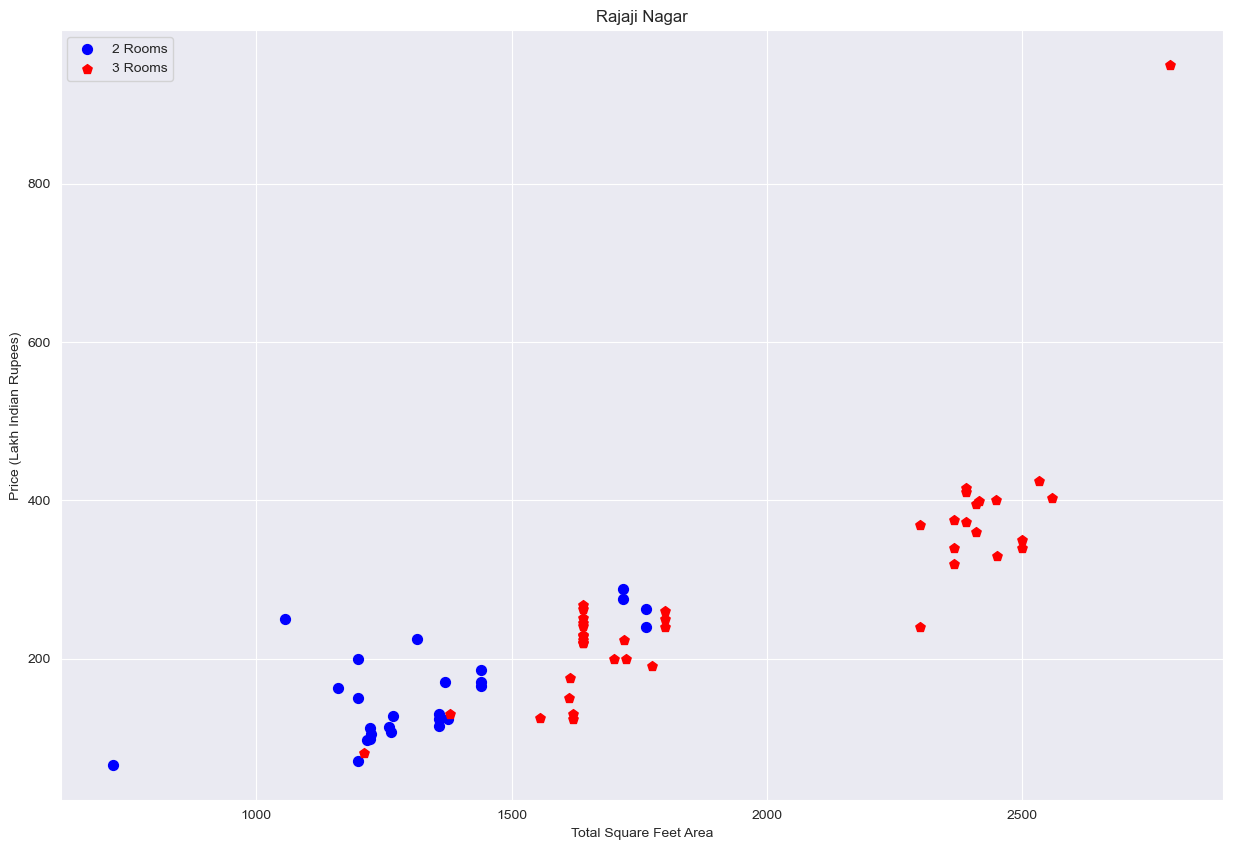

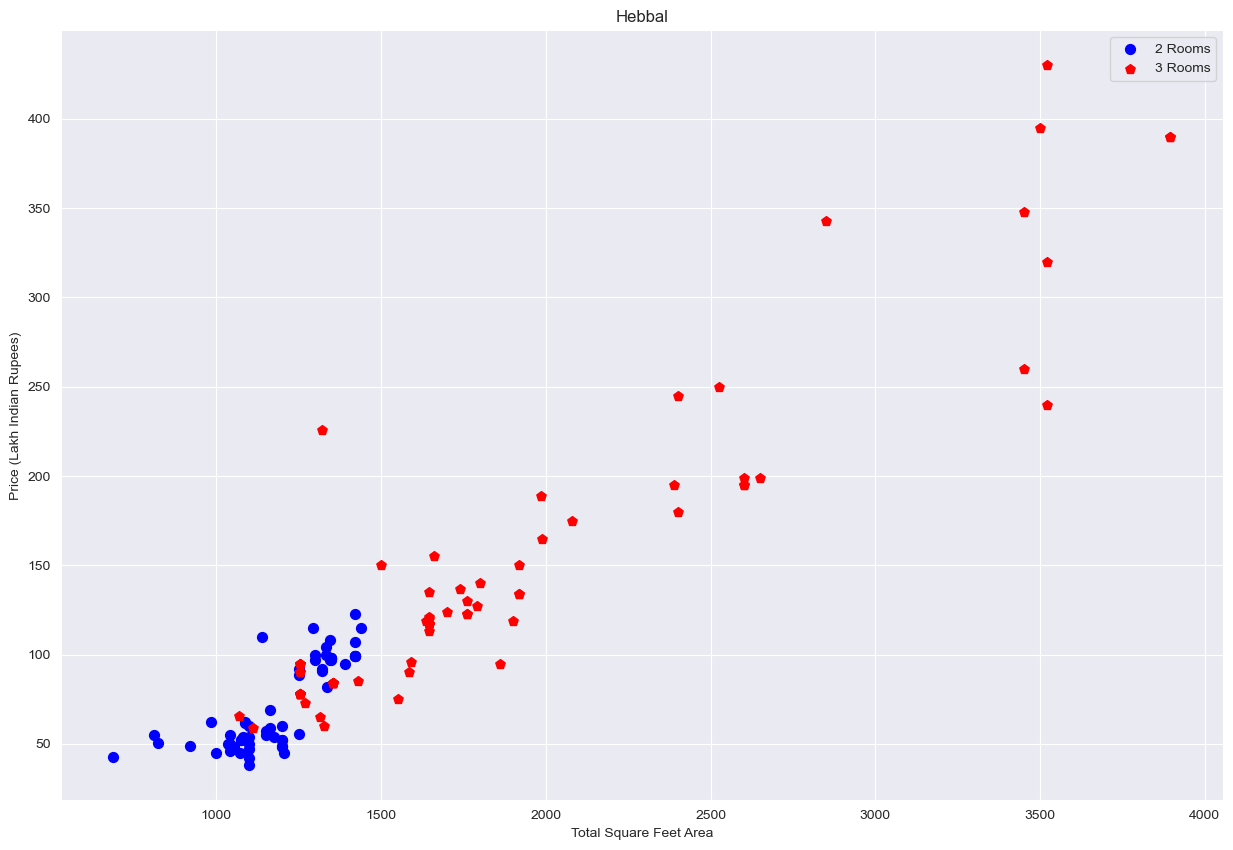

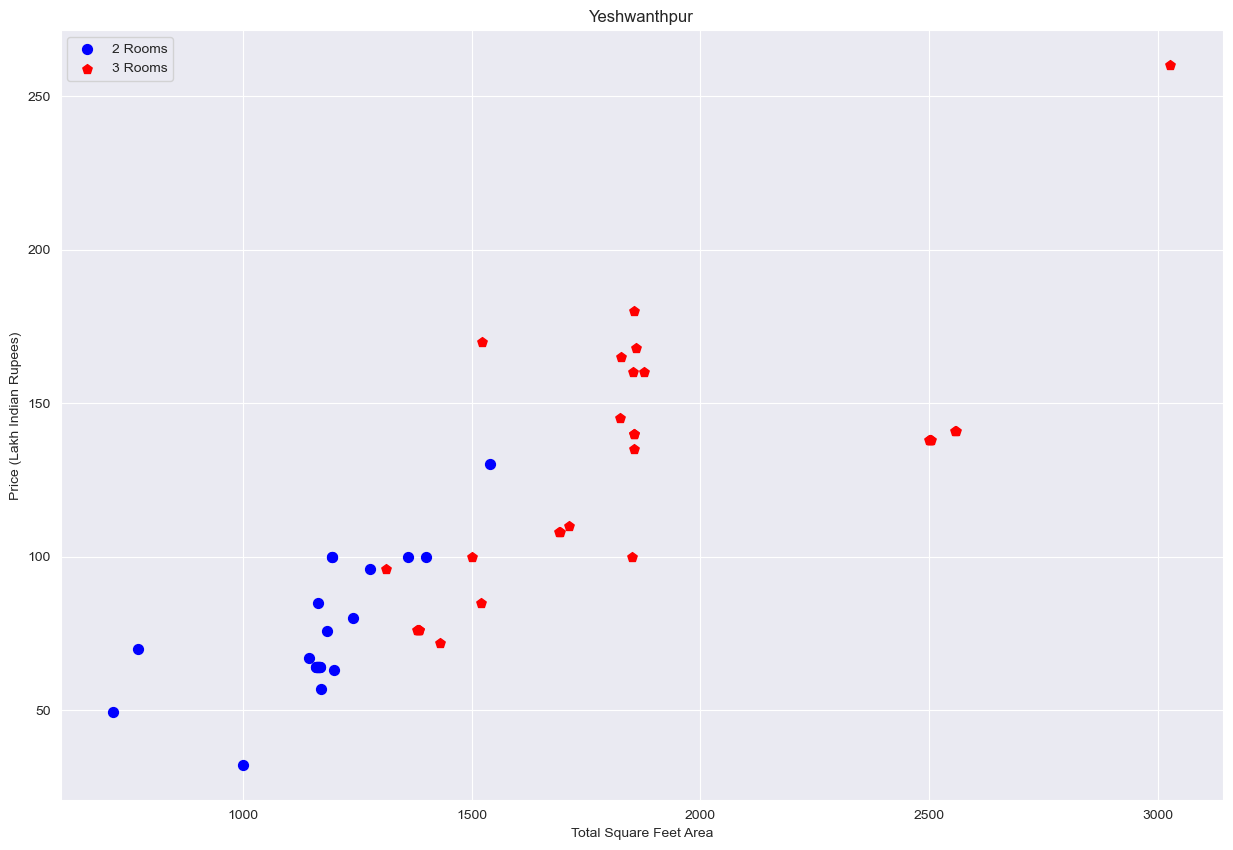

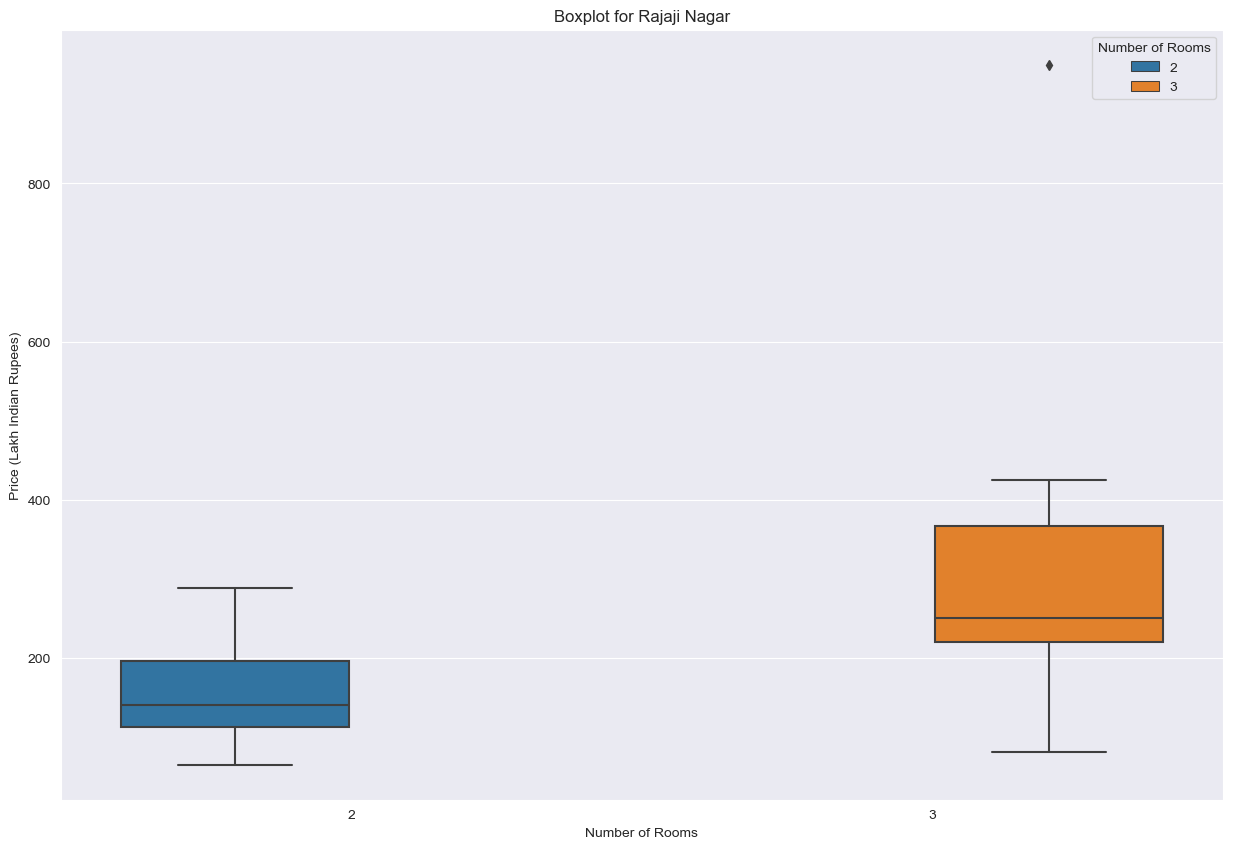

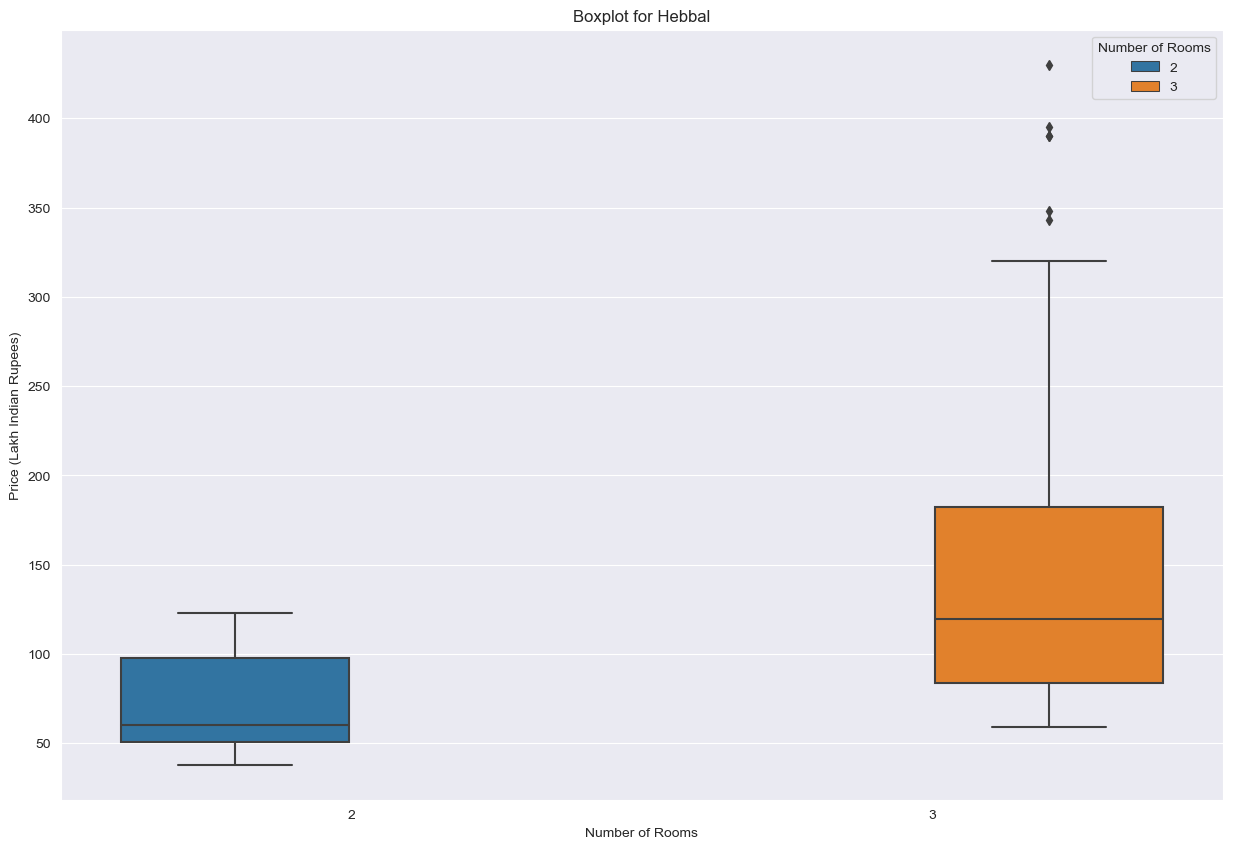

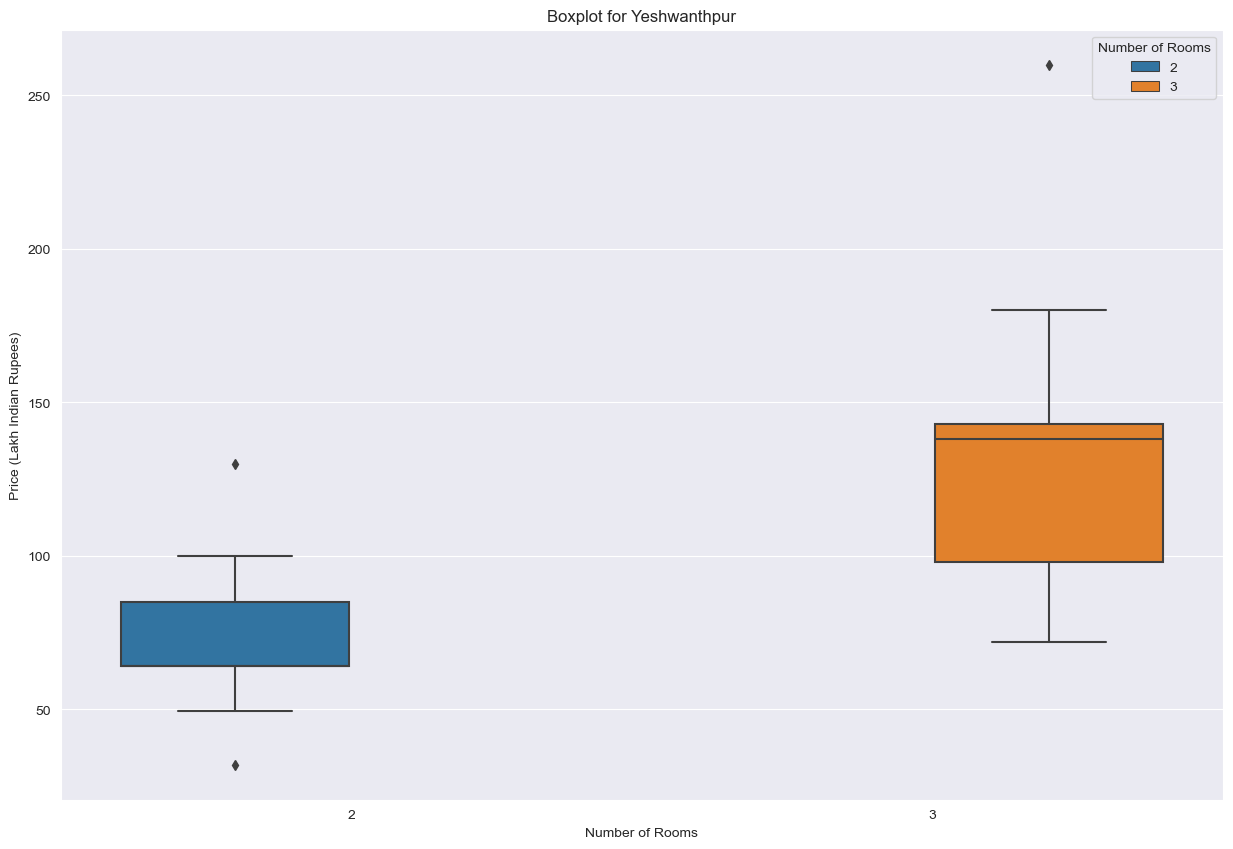

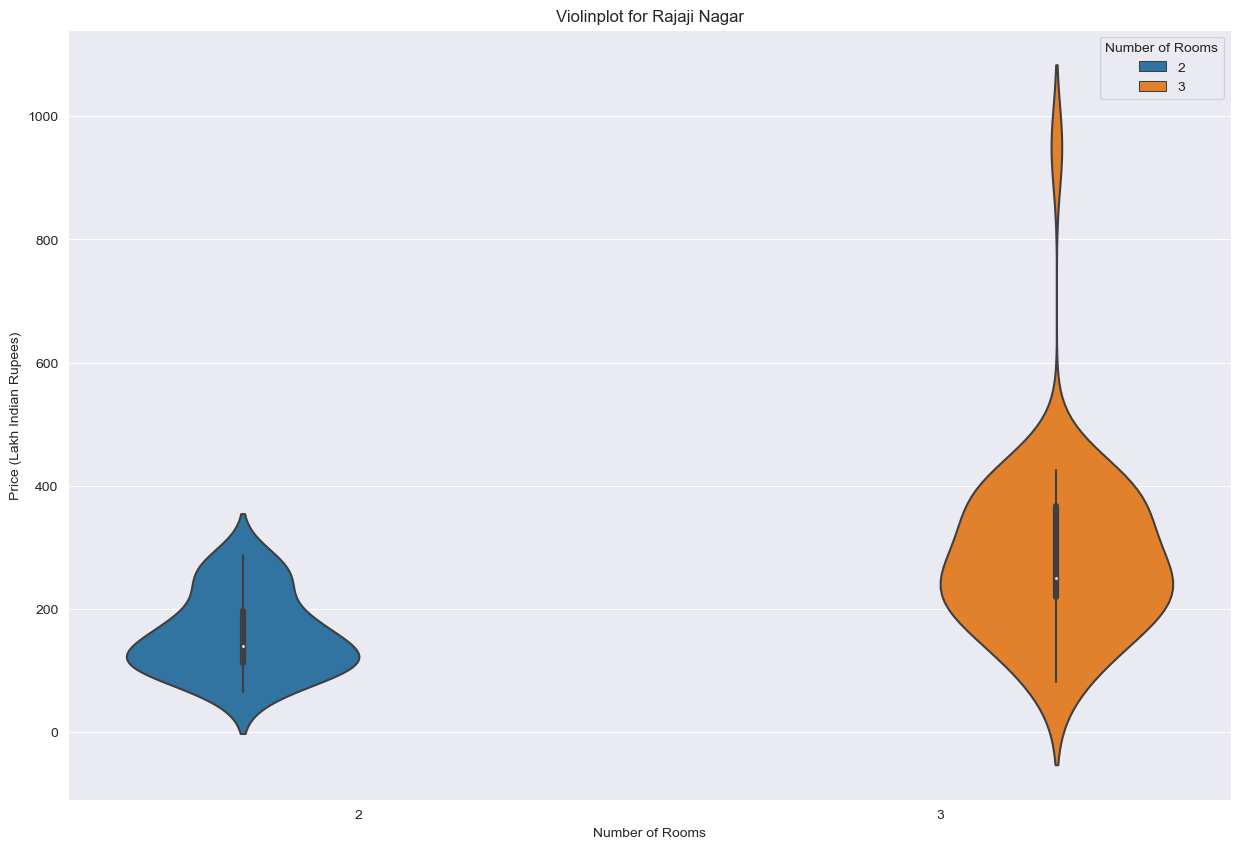

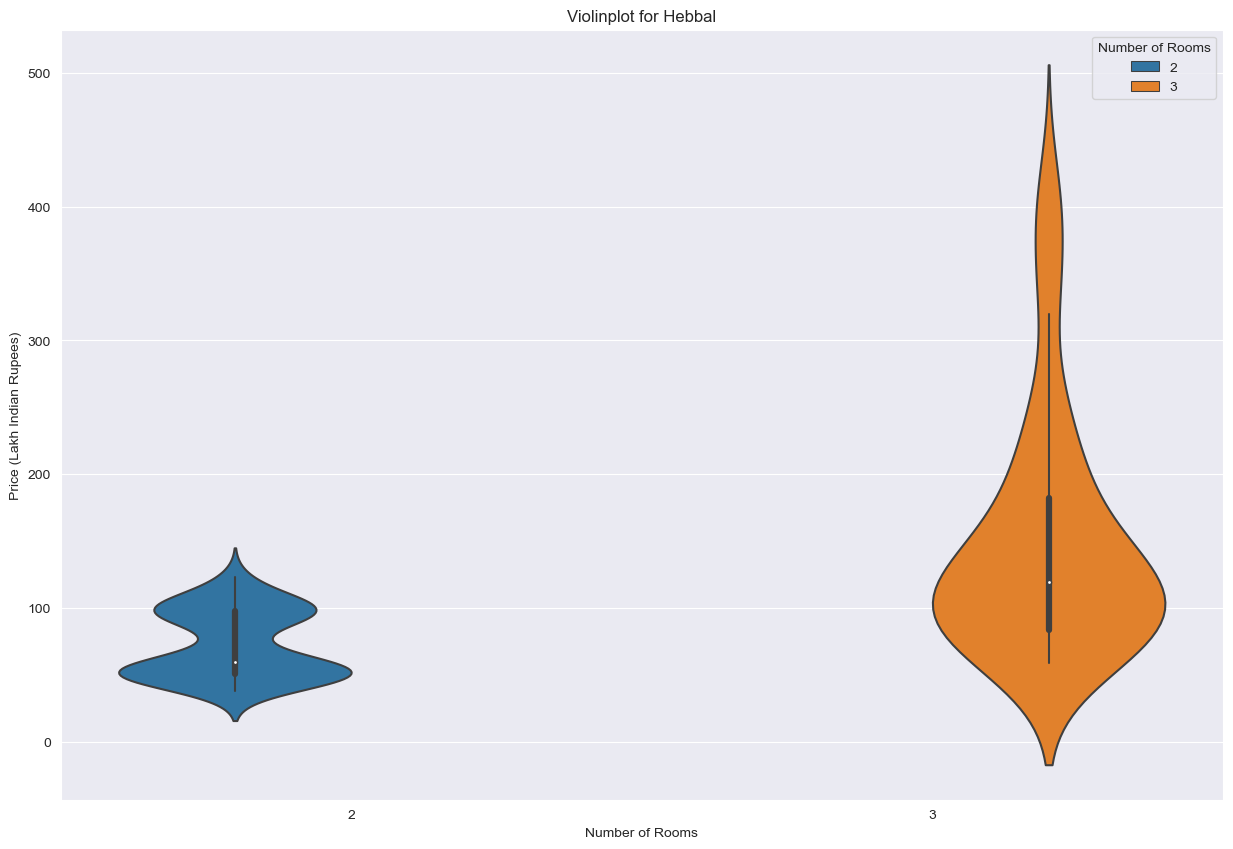

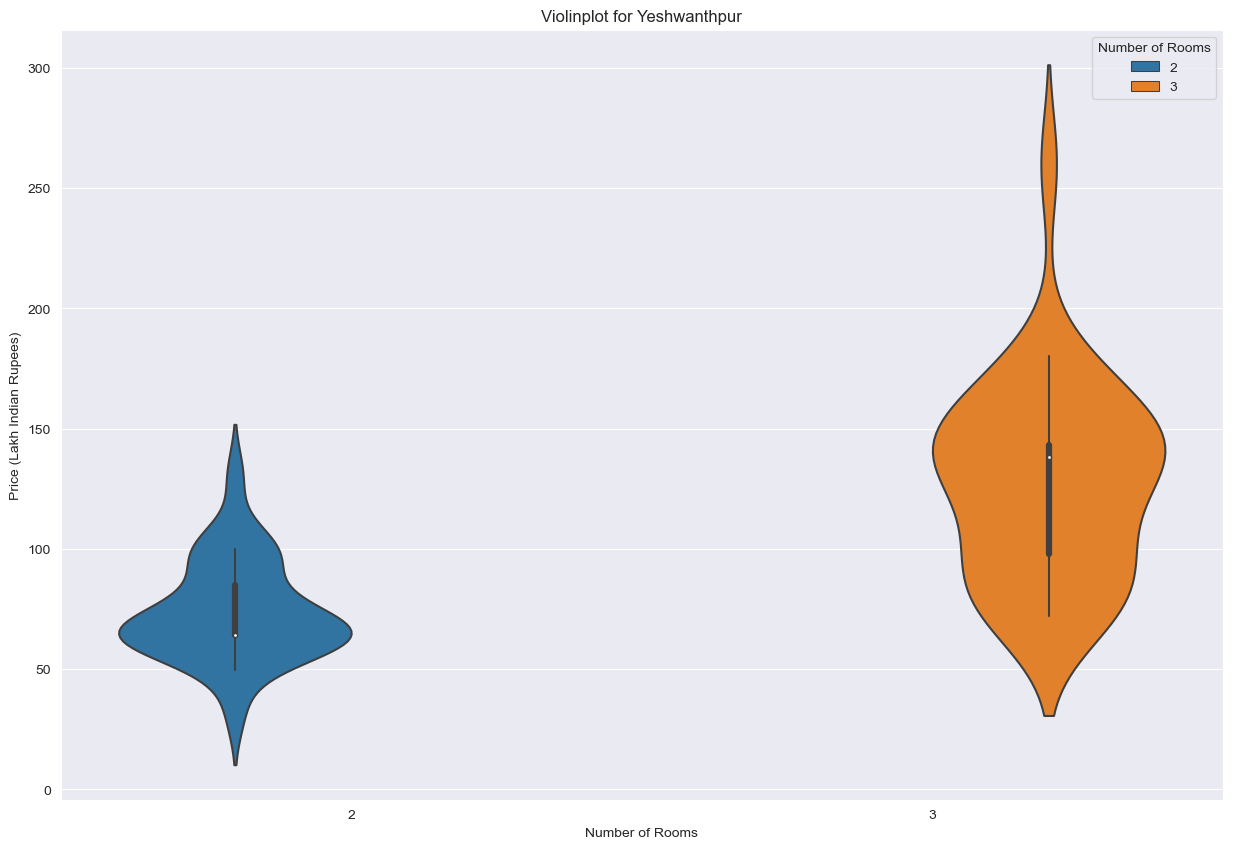

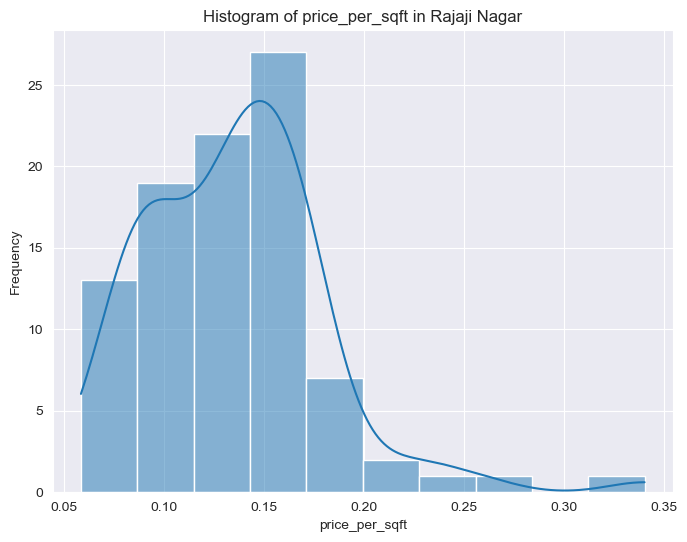

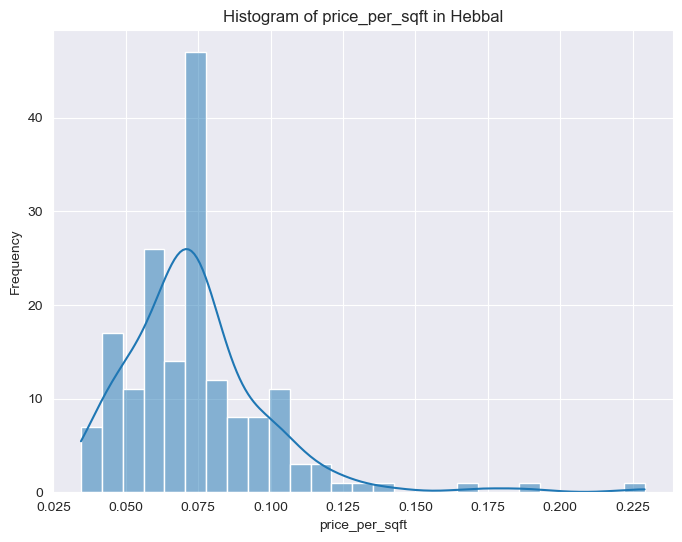

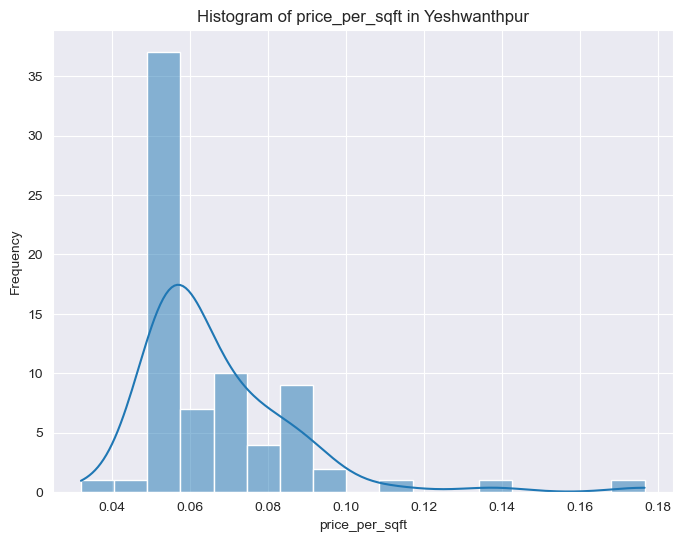

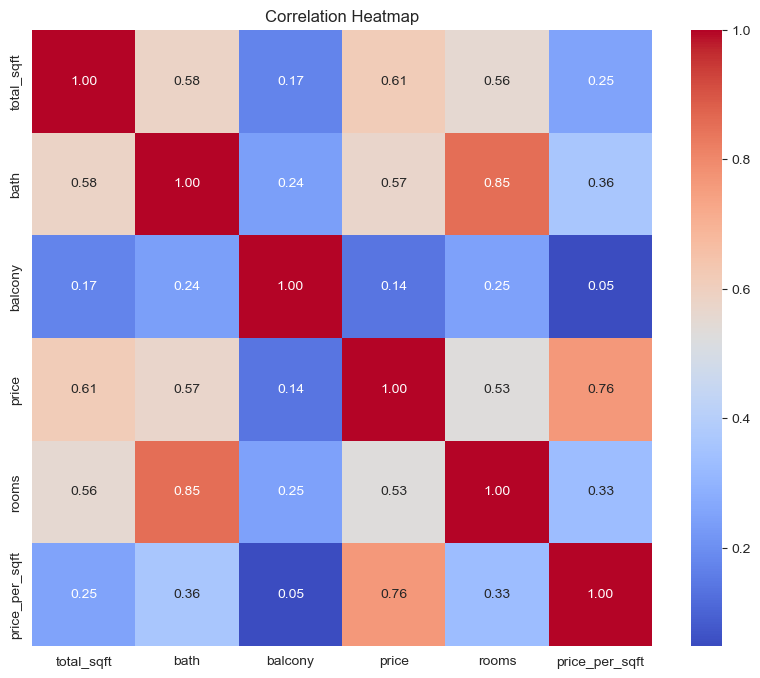

In [13]:
# Show data before outliers in scatter chart
vd.plot_scatter_chart(cleaned_data, "Rajaji Nagar")
vd.plot_scatter_chart(cleaned_data, "Hebbal")
vd.plot_scatter_chart(cleaned_data, "Yeshwanthpur")

# Show data before outliers in box plots
vd.plot_boxplot(cleaned_data, "Rajaji Nagar")
vd.plot_boxplot(cleaned_data, "Hebbal")
vd.plot_boxplot(cleaned_data, "Yeshwanthpur")

# Show data before outliers in violins plot
vd.plot_violinplot(cleaned_data, "Rajaji Nagar")
vd.plot_violinplot(cleaned_data, "Hebbal")
vd.plot_violinplot(cleaned_data, "Yeshwanthpur")

# Show data before outliers in histograms
vd.plot_histogram(cleaned_data, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(cleaned_data, "price_per_sqft", "Hebbal")
vd.plot_histogram(cleaned_data, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(cleaned_data)

In [14]:
# Removes first demand of outliers
first_outliers = rm.remove_prices_outliers(cleaned_data)

# Show data
first_outliers

,location,total_sqft,bath,balcony,price,rooms,price_per_sqft
0,Devarachikkanahalli,1116.0,2.0,1.0,47.000,2,0.042115
1,Devarachikkanahalli,1425.0,2.0,2.0,65.000,3,0.045614
2,Devarachikkanahalli,1417.0,2.0,2.0,76.000,3,0.053634
3,Devarachikkanahalli,991.0,2.0,2.0,40.000,2,0.040363
4,Devarachikkanahalli,1250.0,2.0,3.0,44.000,3,0.035200
...,...,...,...,...,...,...,...
7712,Yeshwanthpur,1855.0,3.0,3.0,140.000,3,0.075472
7713,Yeshwanthpur,1195.0,2.0,2.0,100.000,2,0.083682
7714,Yeshwanthpur,3027.0,4.0,3.0,260.000,3,0.085894
7715,Yeshwanthpur,605.0,1.0,0.0,41.745,1,0.069000


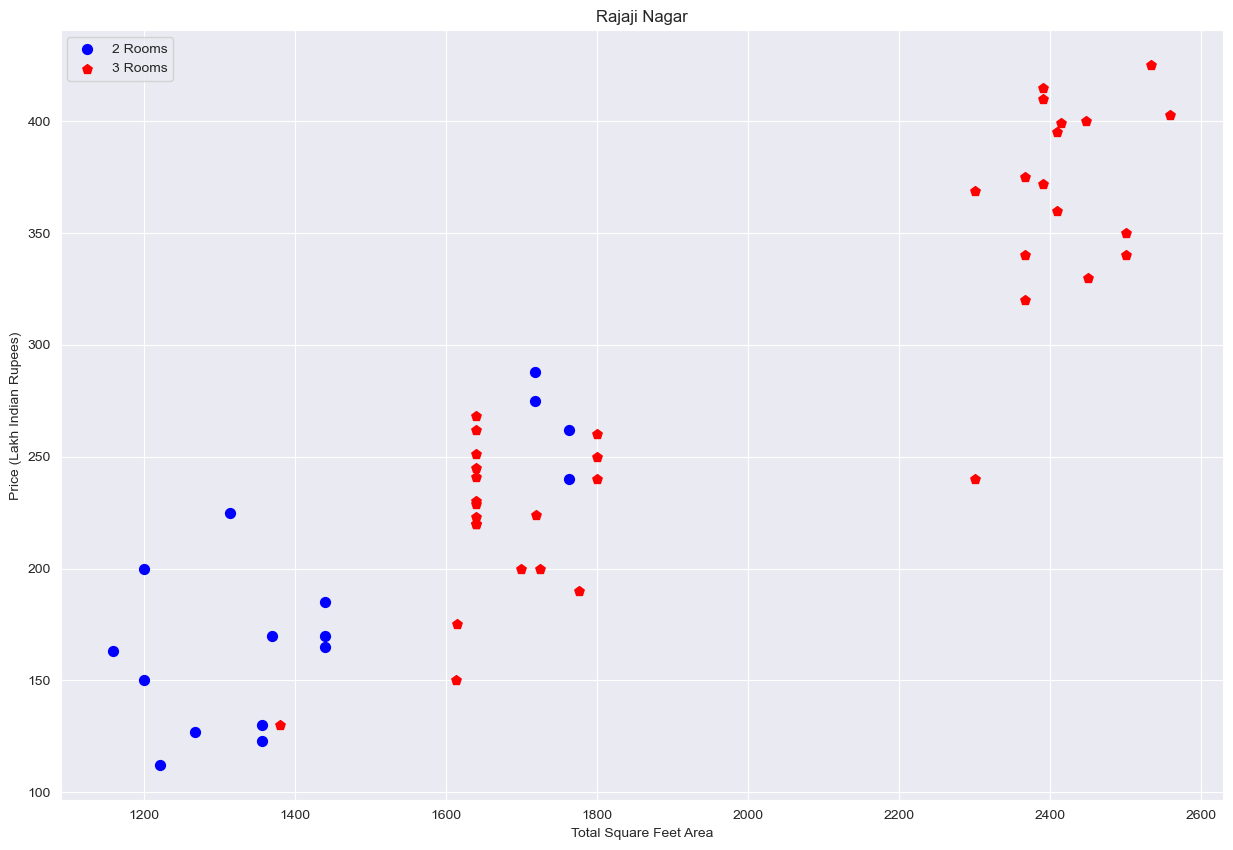

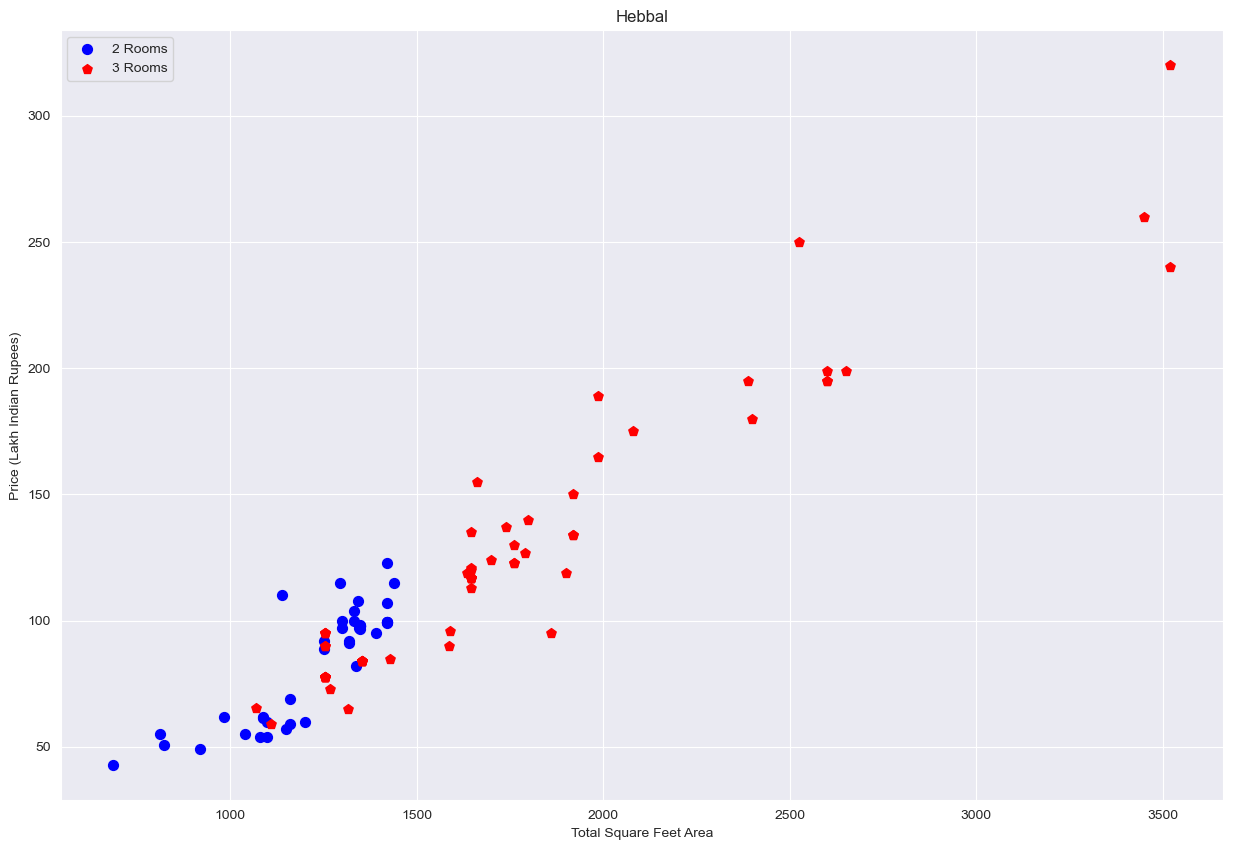

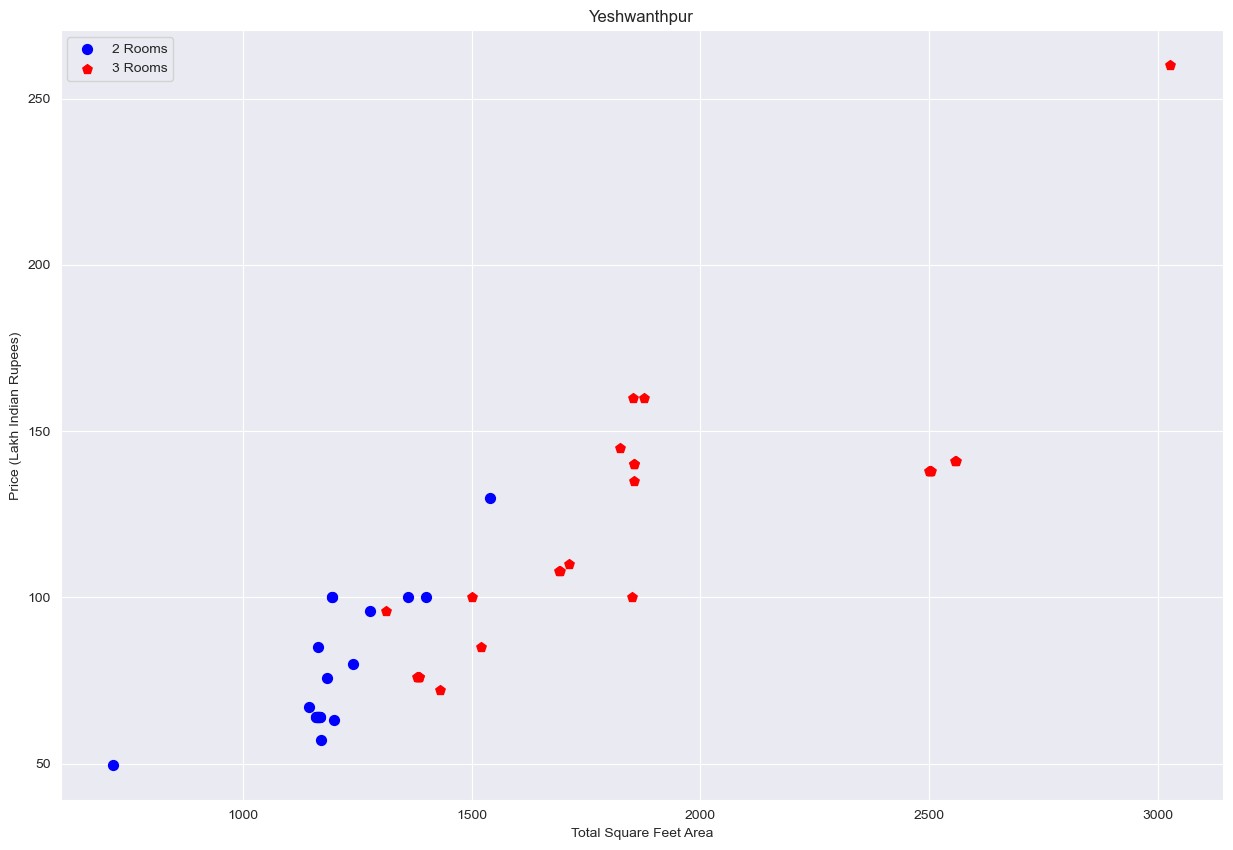

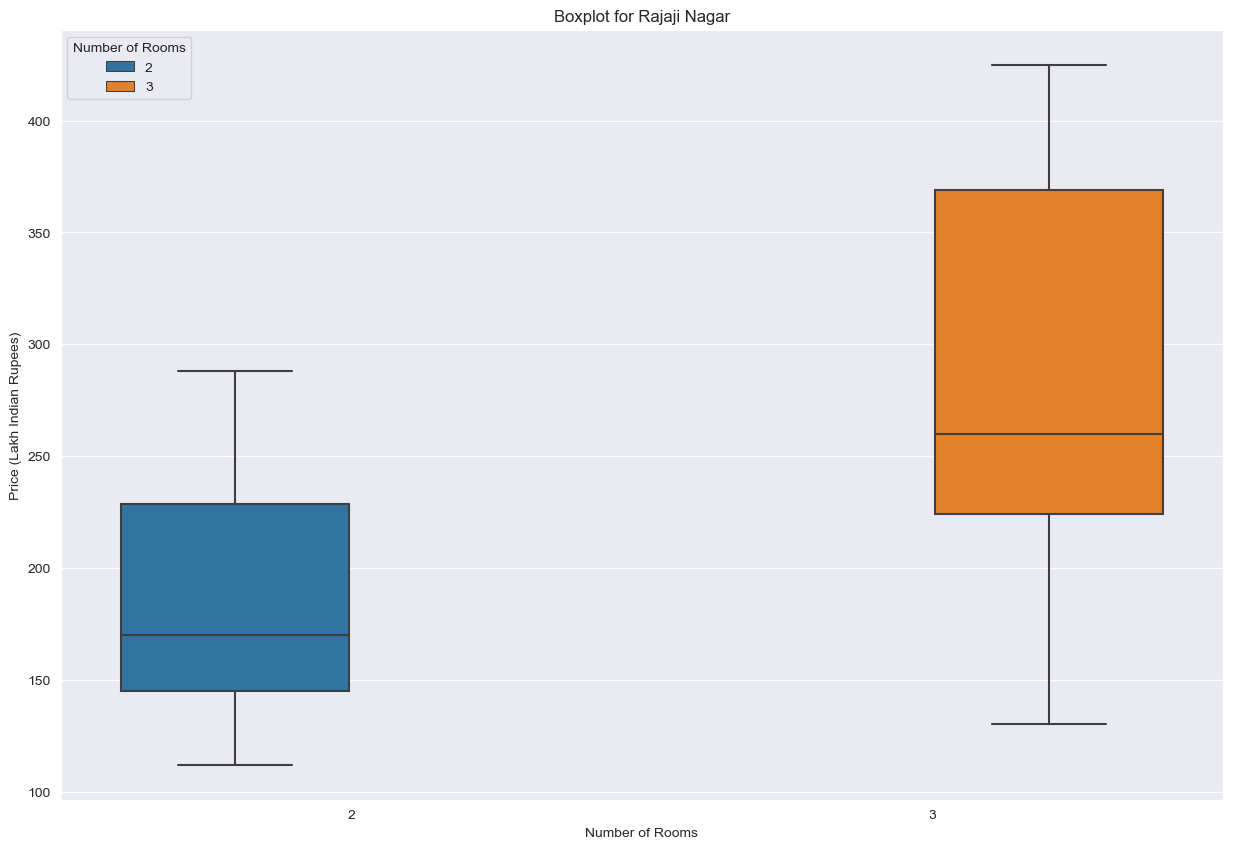

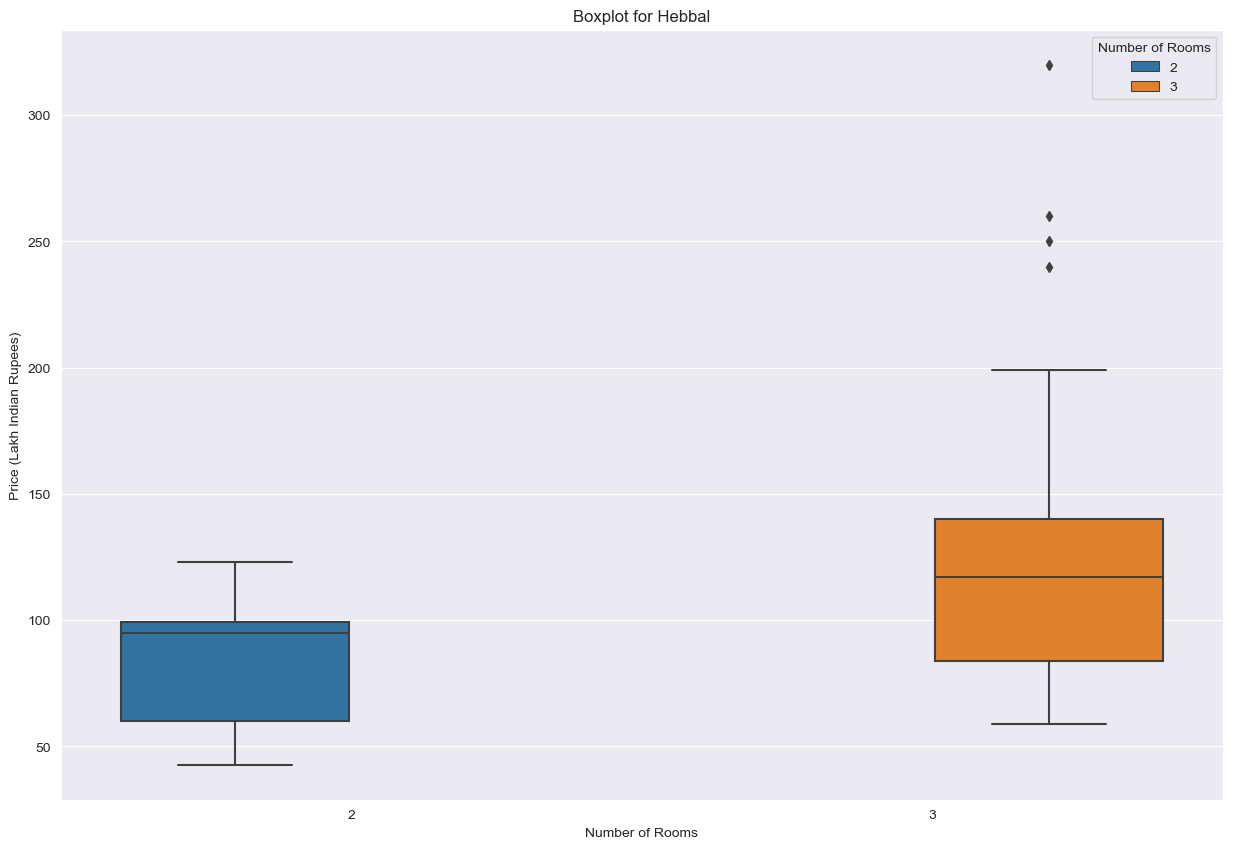

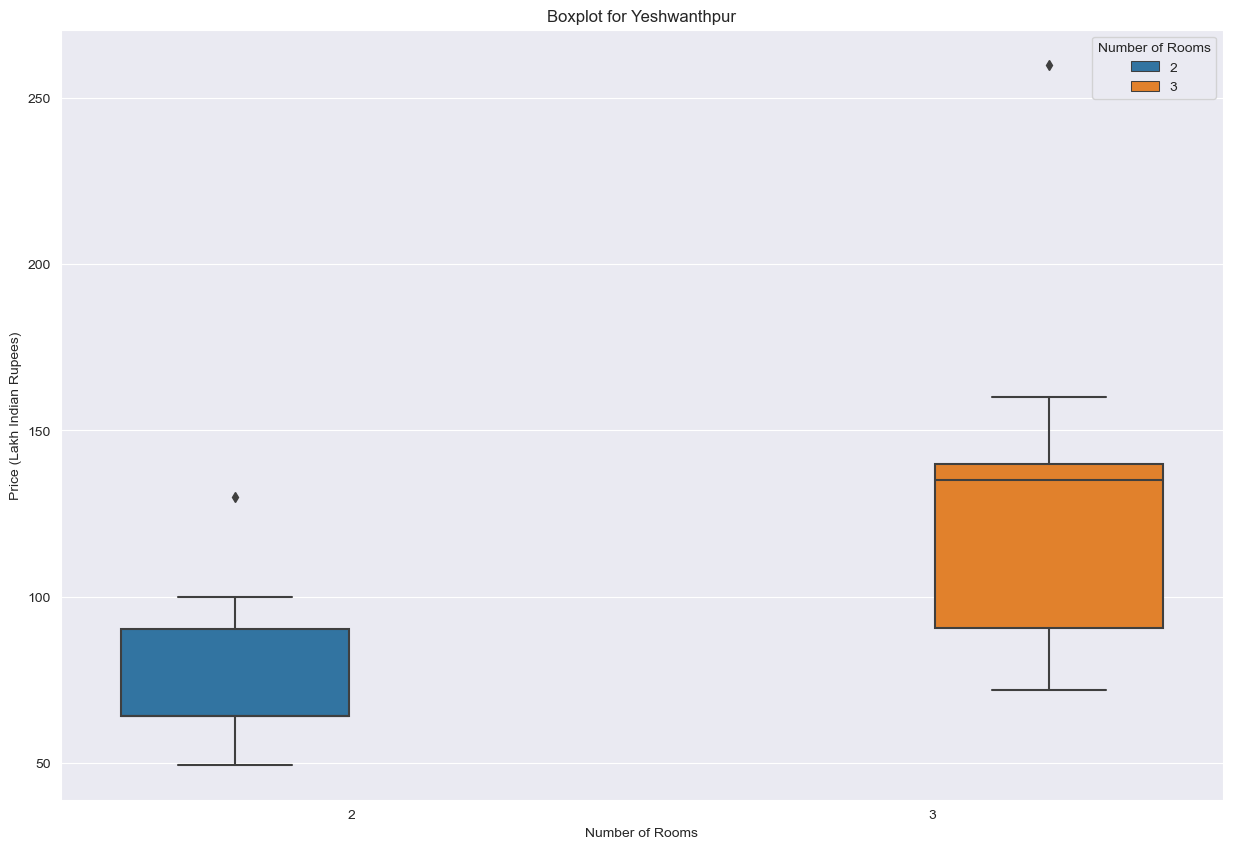

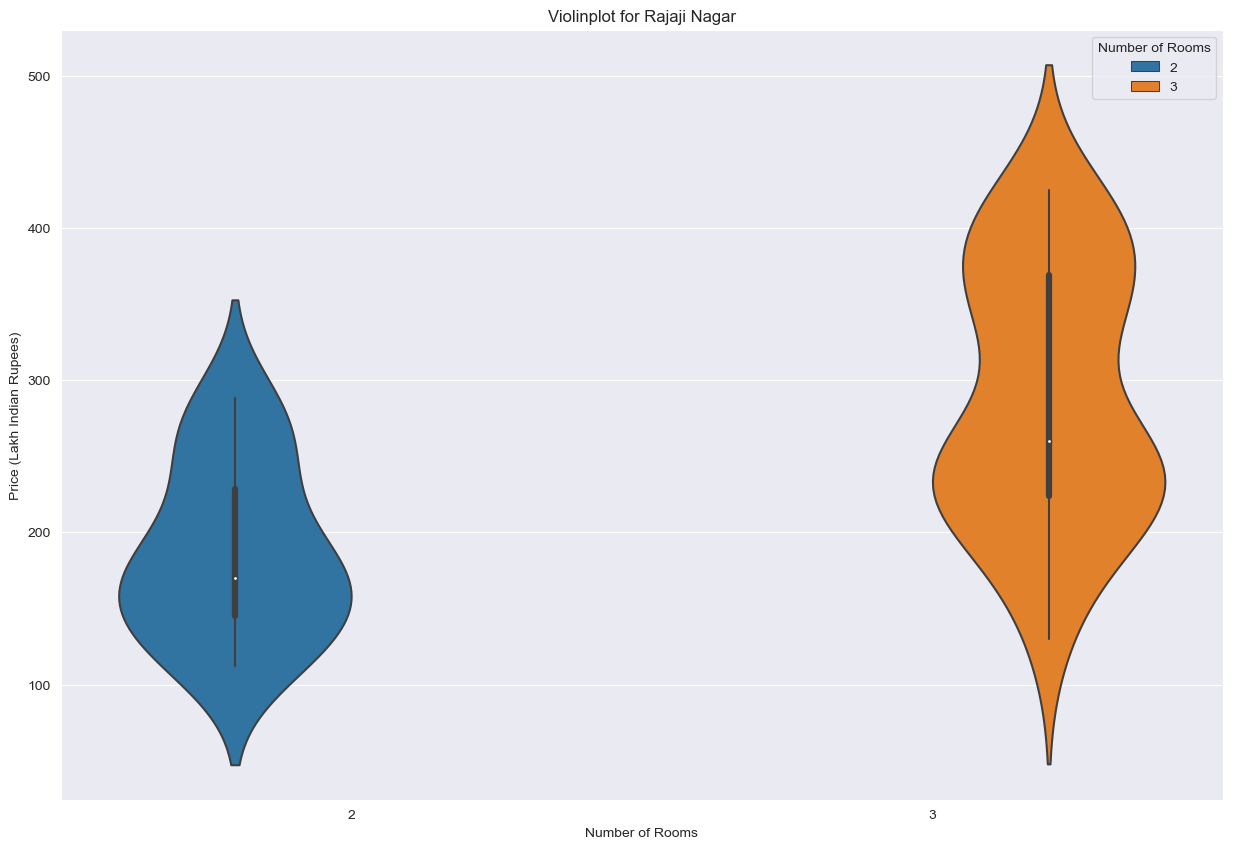

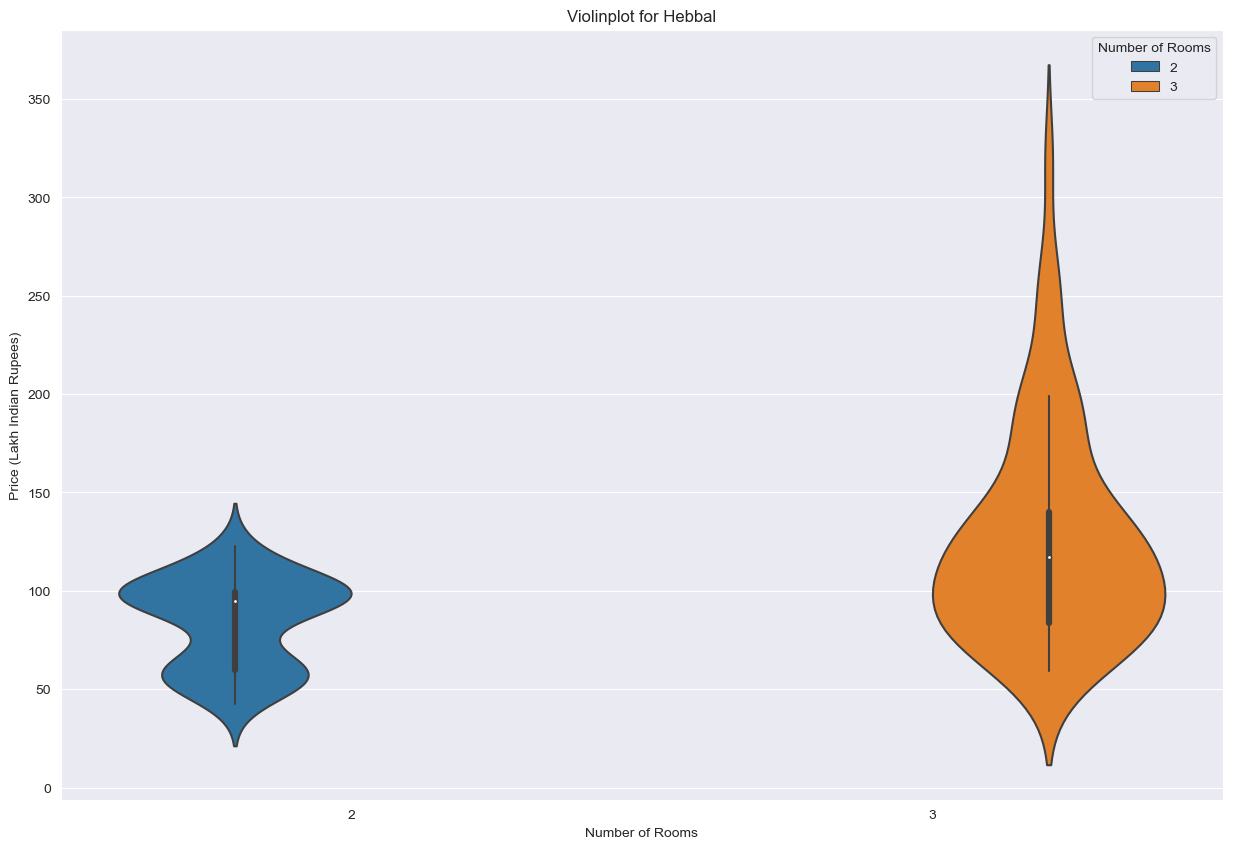

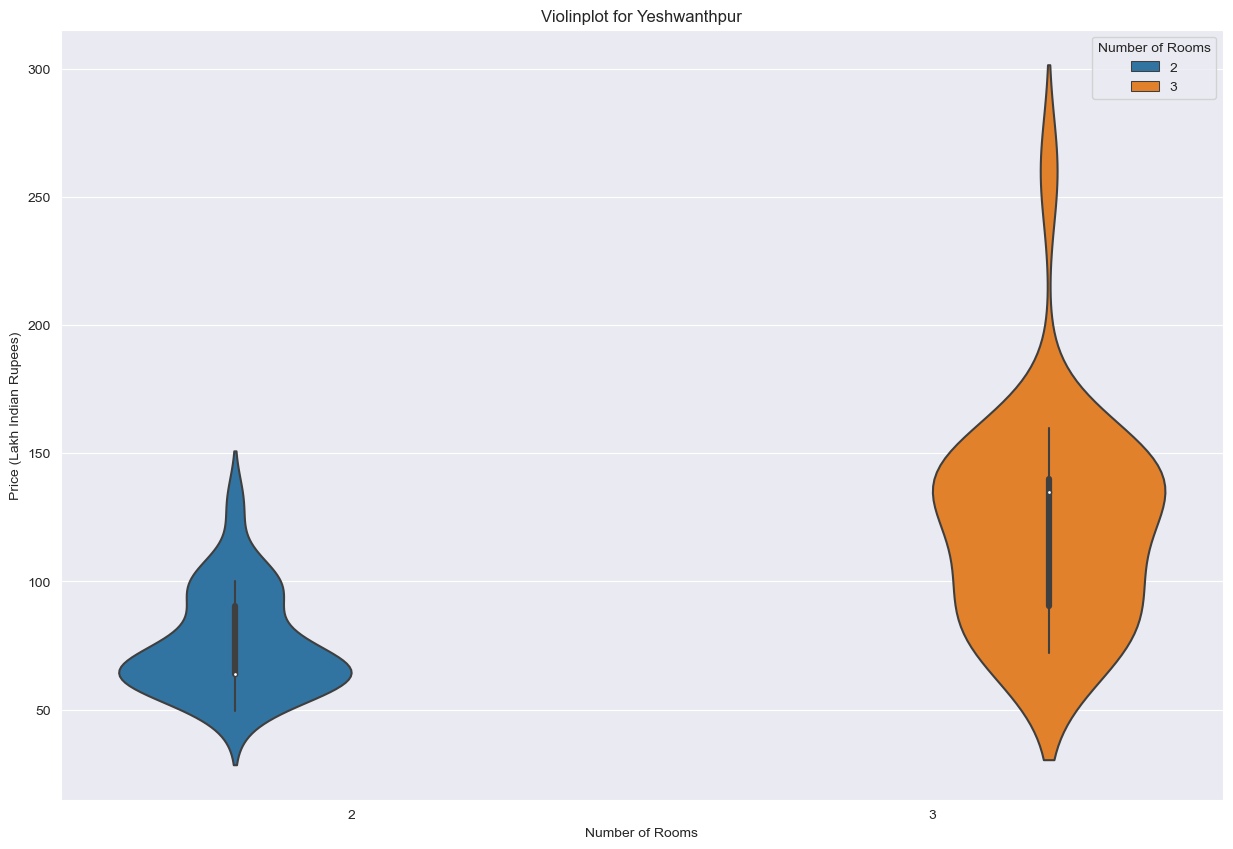

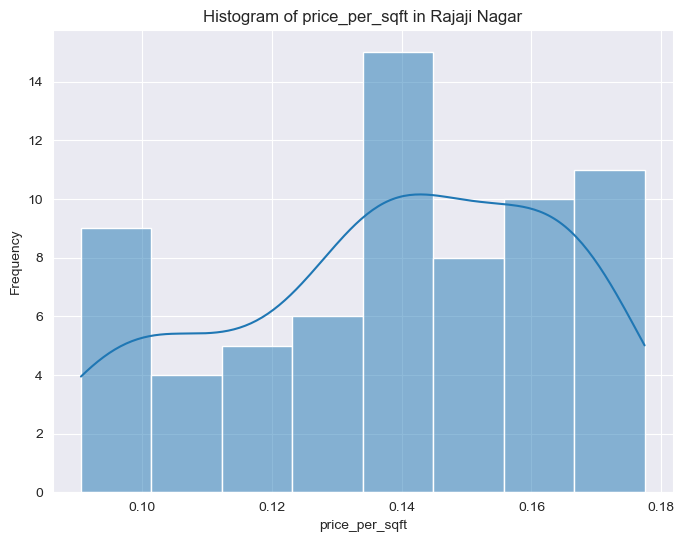

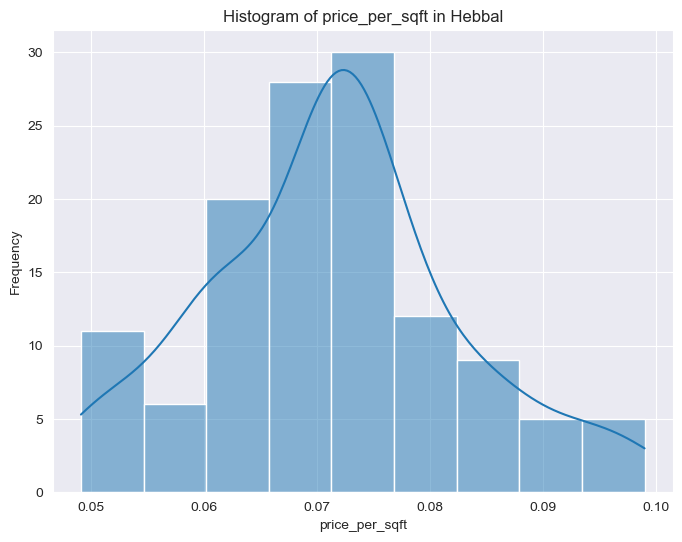

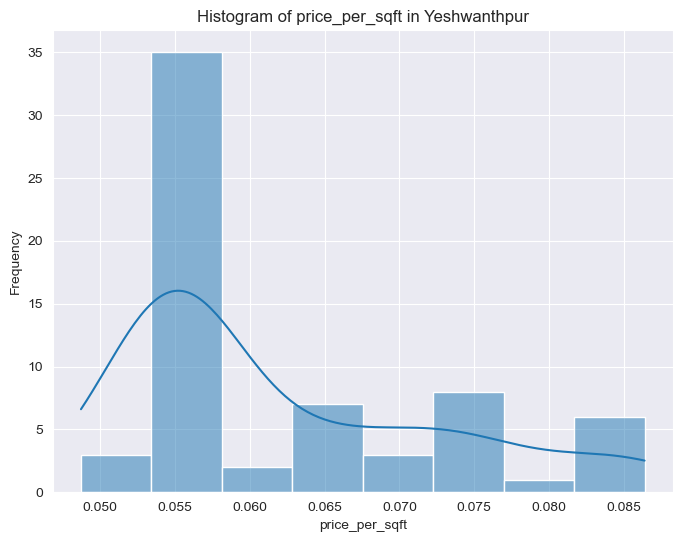

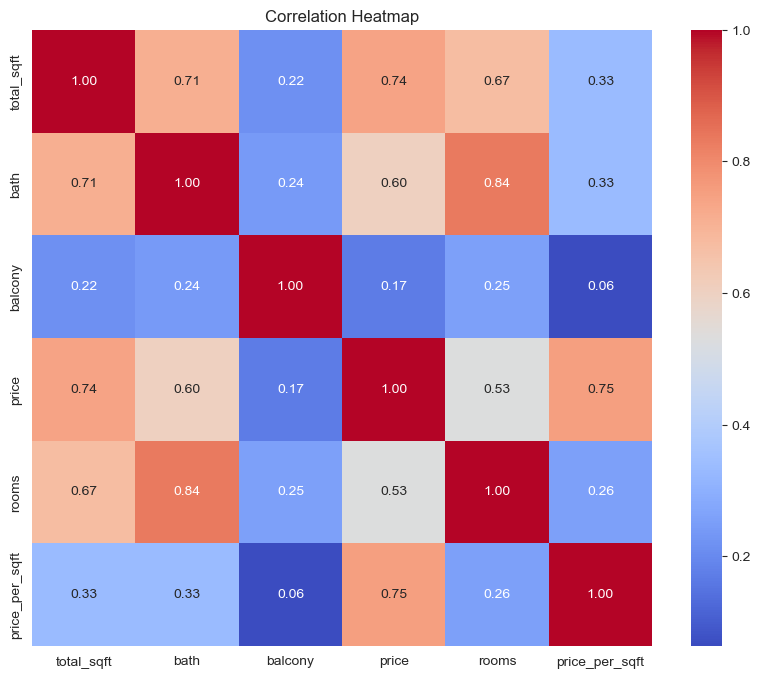

In [15]:
# See the scatter plots before the second removal
vd.plot_scatter_chart(first_outliers, "Rajaji Nagar")
vd.plot_scatter_chart(first_outliers, "Hebbal")
vd.plot_scatter_chart(first_outliers, "Yeshwanthpur")

# Show data before the second removal in box plots
vd.plot_boxplot(first_outliers, "Rajaji Nagar")
vd.plot_boxplot(first_outliers, "Hebbal")
vd.plot_boxplot(first_outliers, "Yeshwanthpur")

# Show data before the second removals in violins plot
vd.plot_violinplot(first_outliers, "Rajaji Nagar")
vd.plot_violinplot(first_outliers, "Hebbal")
vd.plot_violinplot(first_outliers, "Yeshwanthpur")

# Show data before the second removal in histograms
vd.plot_histogram(first_outliers, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(first_outliers, "price_per_sqft", "Hebbal")
vd.plot_histogram(first_outliers, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(first_outliers)

In [16]:
# Removes second demand of outliers
second_outliers = rm.remove_bedroom_outliers(first_outliers)

# Show data 
second_outliers

,location,total_sqft,bath,balcony,price,rooms,price_per_sqft
0,Devarachikkanahalli,1116.0,2.0,1.0,47.000,2,0.042115
1,Devarachikkanahalli,1425.0,2.0,2.0,65.000,3,0.045614
2,Devarachikkanahalli,1417.0,2.0,2.0,76.000,3,0.053634
3,Devarachikkanahalli,991.0,2.0,2.0,40.000,2,0.040363
5,Devarachikkanahalli,947.0,2.0,2.0,43.000,2,0.045407
...,...,...,...,...,...,...,...
7712,Yeshwanthpur,1855.0,3.0,3.0,140.000,3,0.075472
7713,Yeshwanthpur,1195.0,2.0,2.0,100.000,2,0.083682
7714,Yeshwanthpur,3027.0,4.0,3.0,260.000,3,0.085894
7715,Yeshwanthpur,605.0,1.0,0.0,41.745,1,0.069000


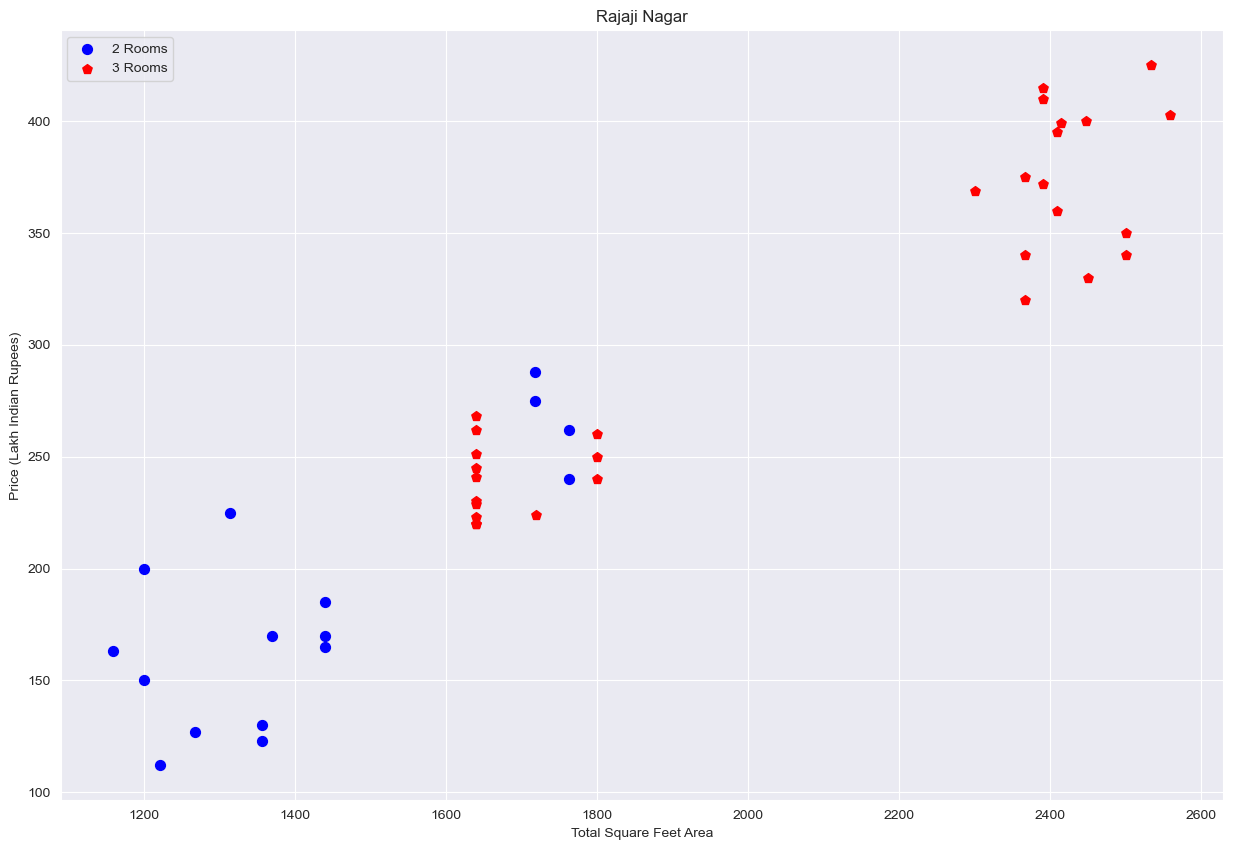

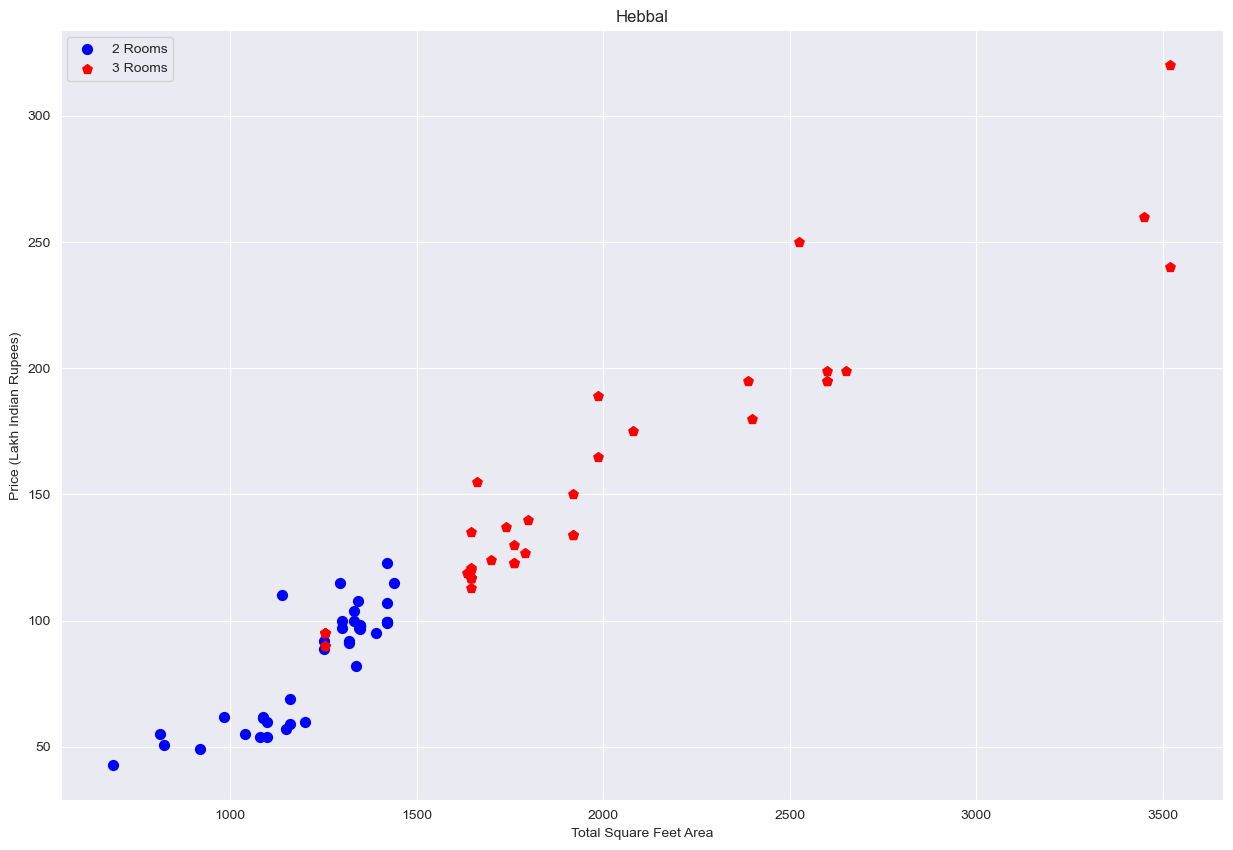

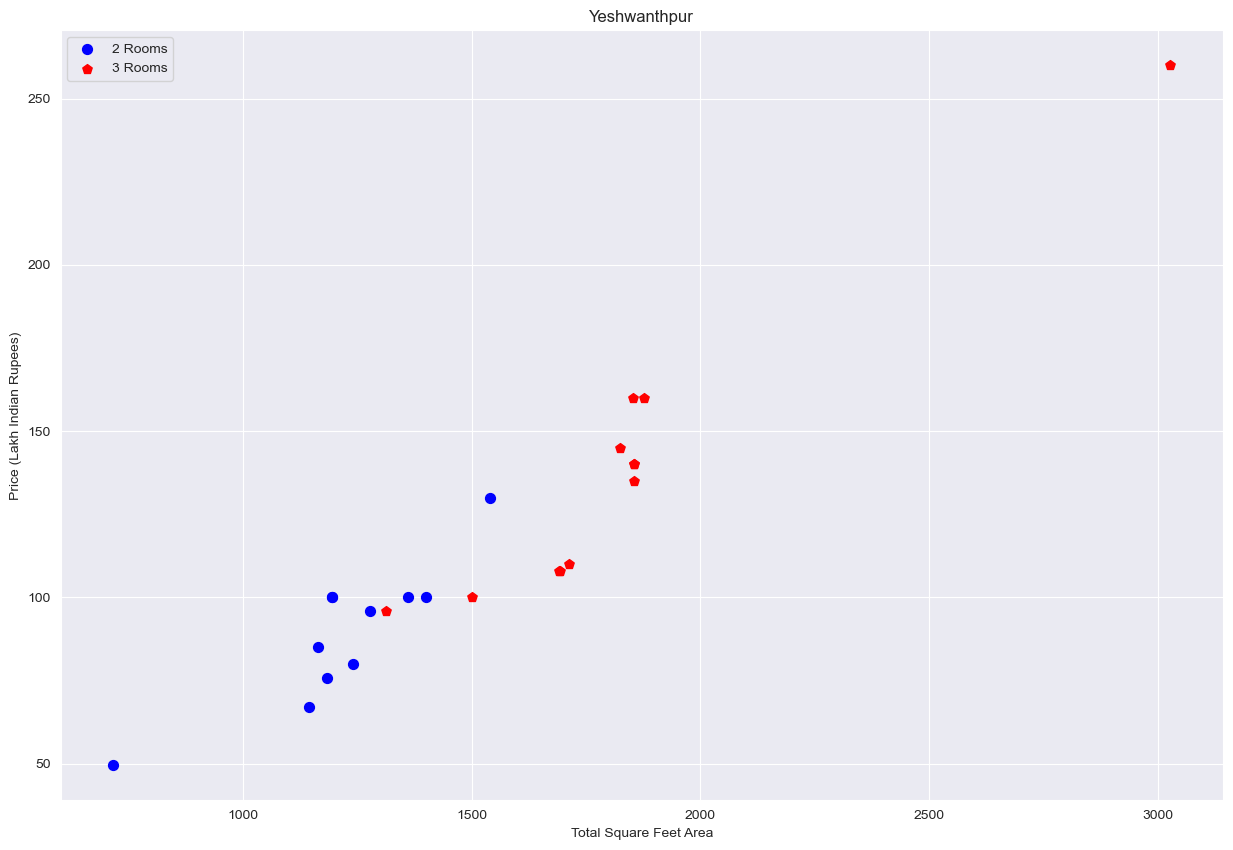

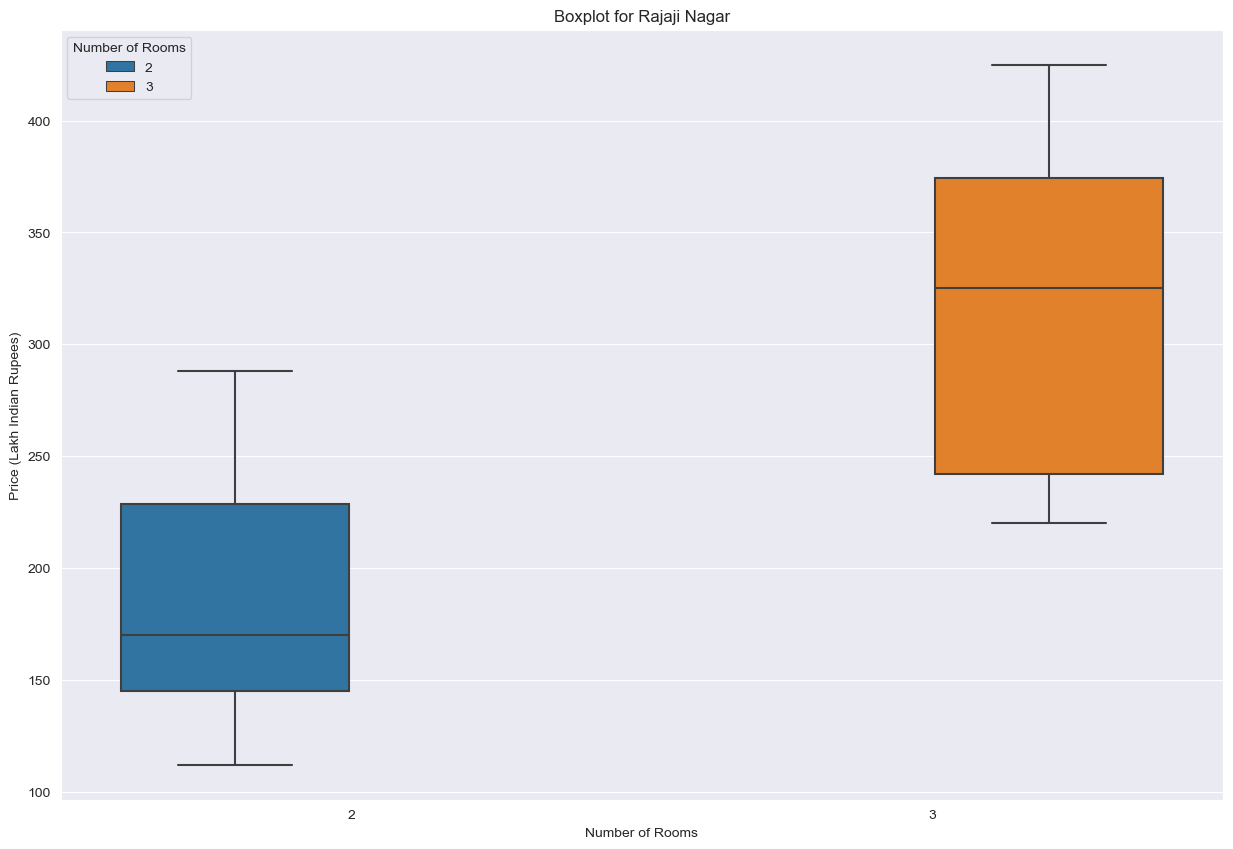

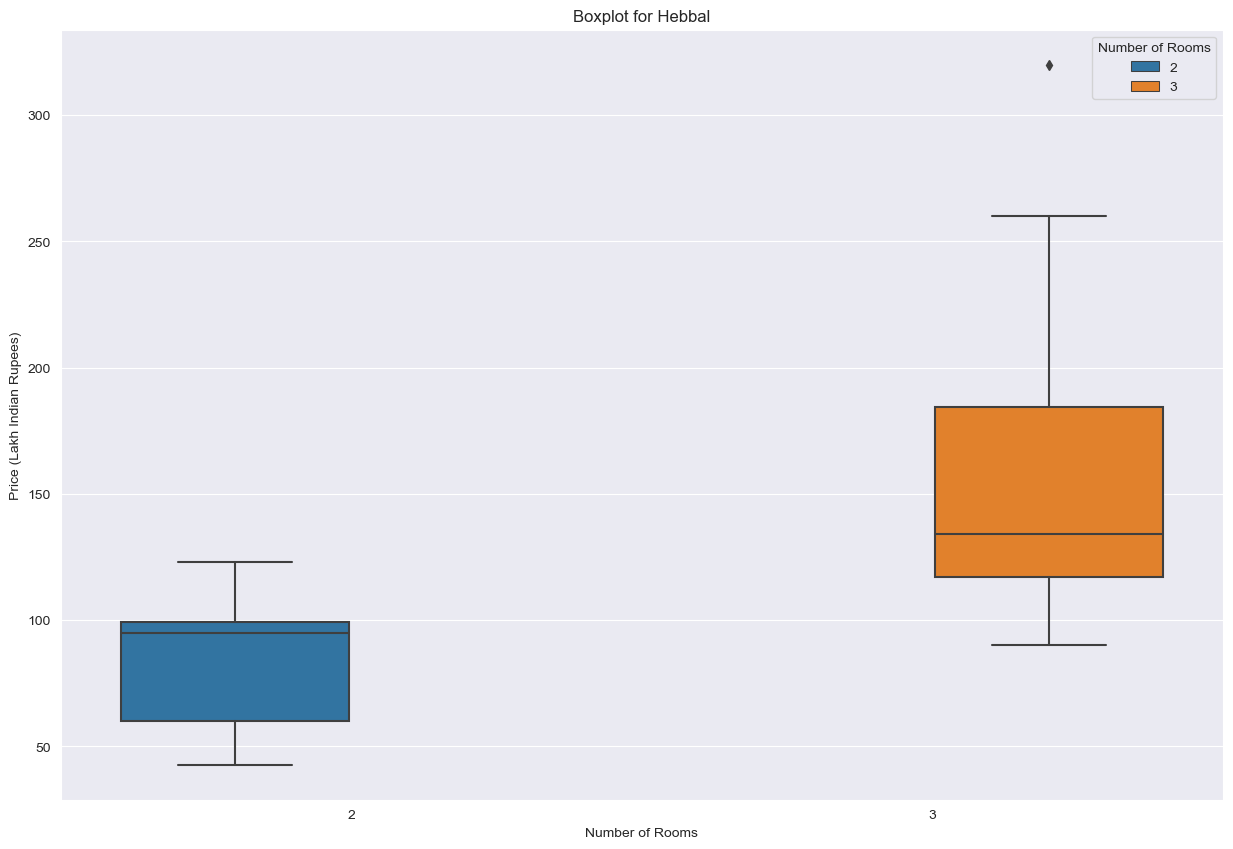

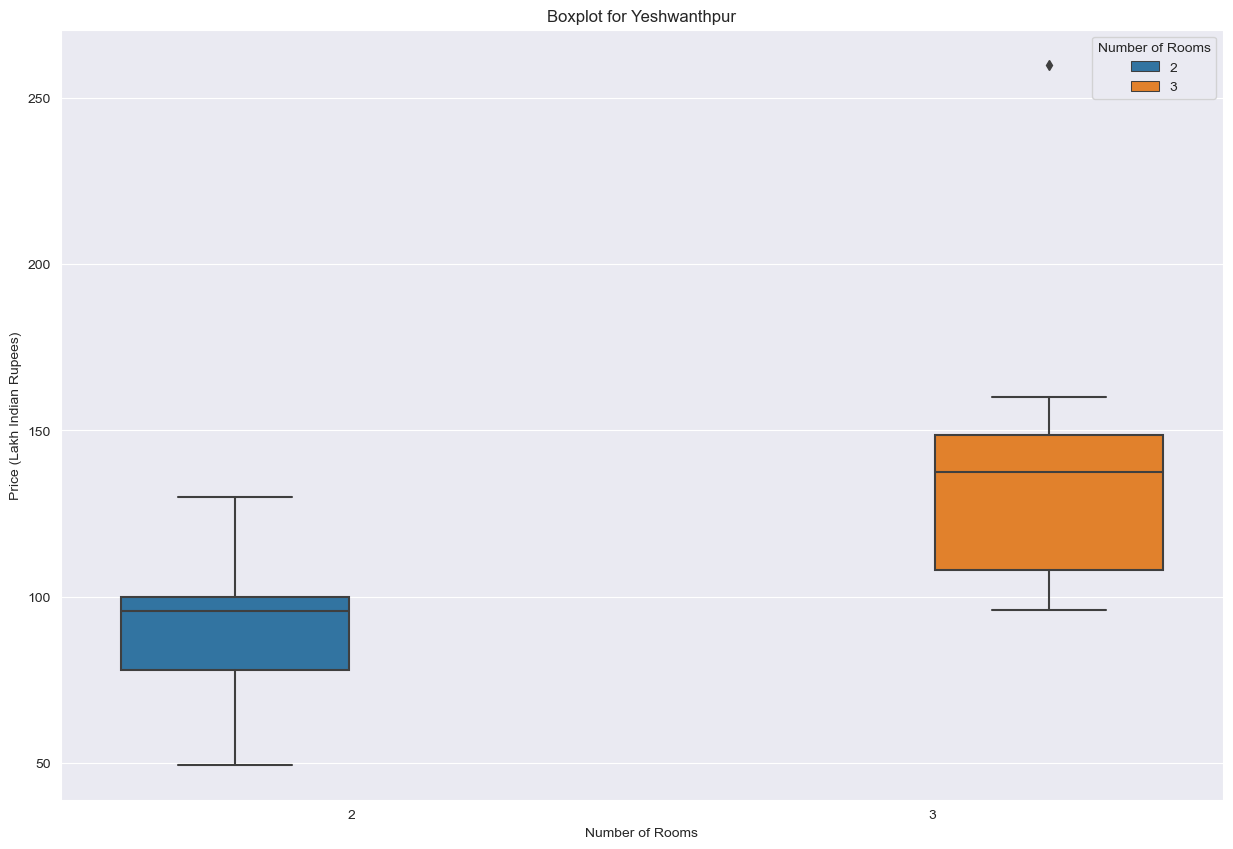

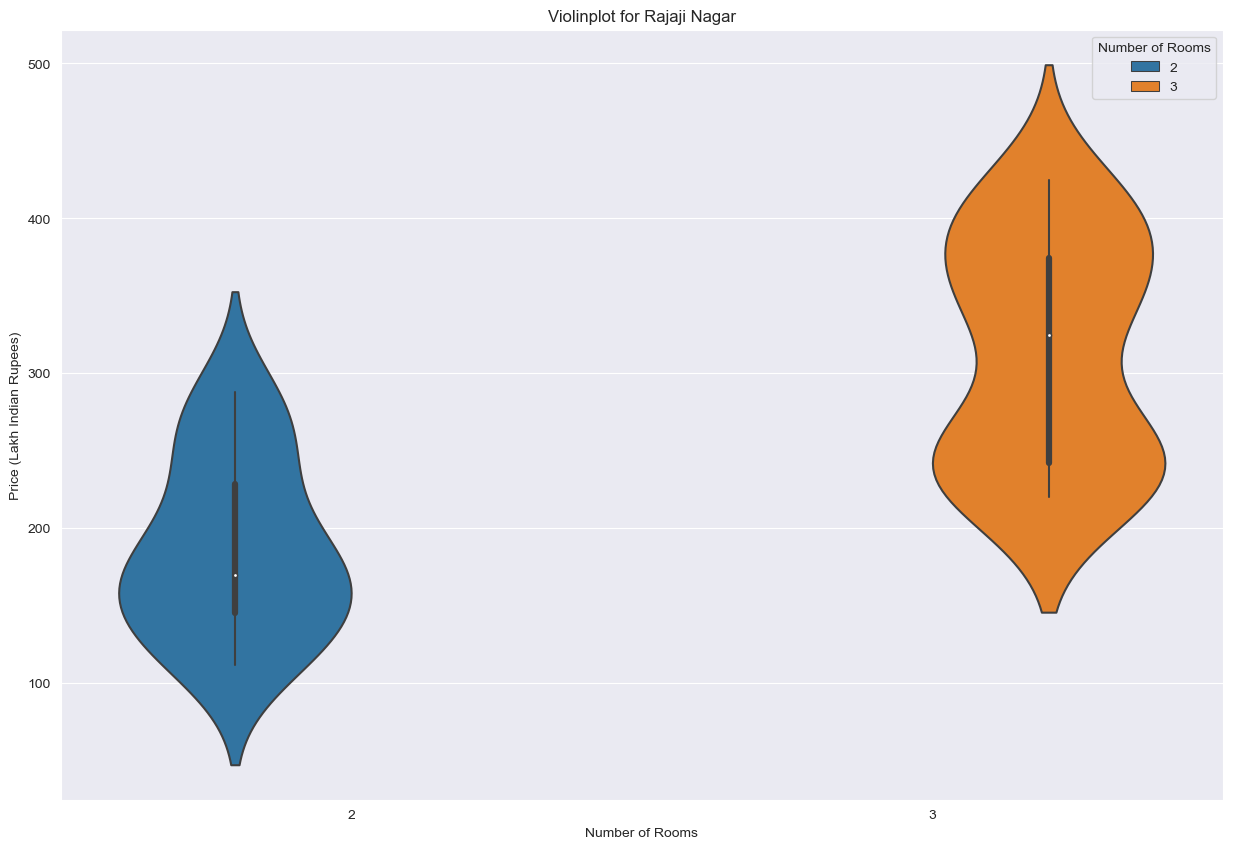

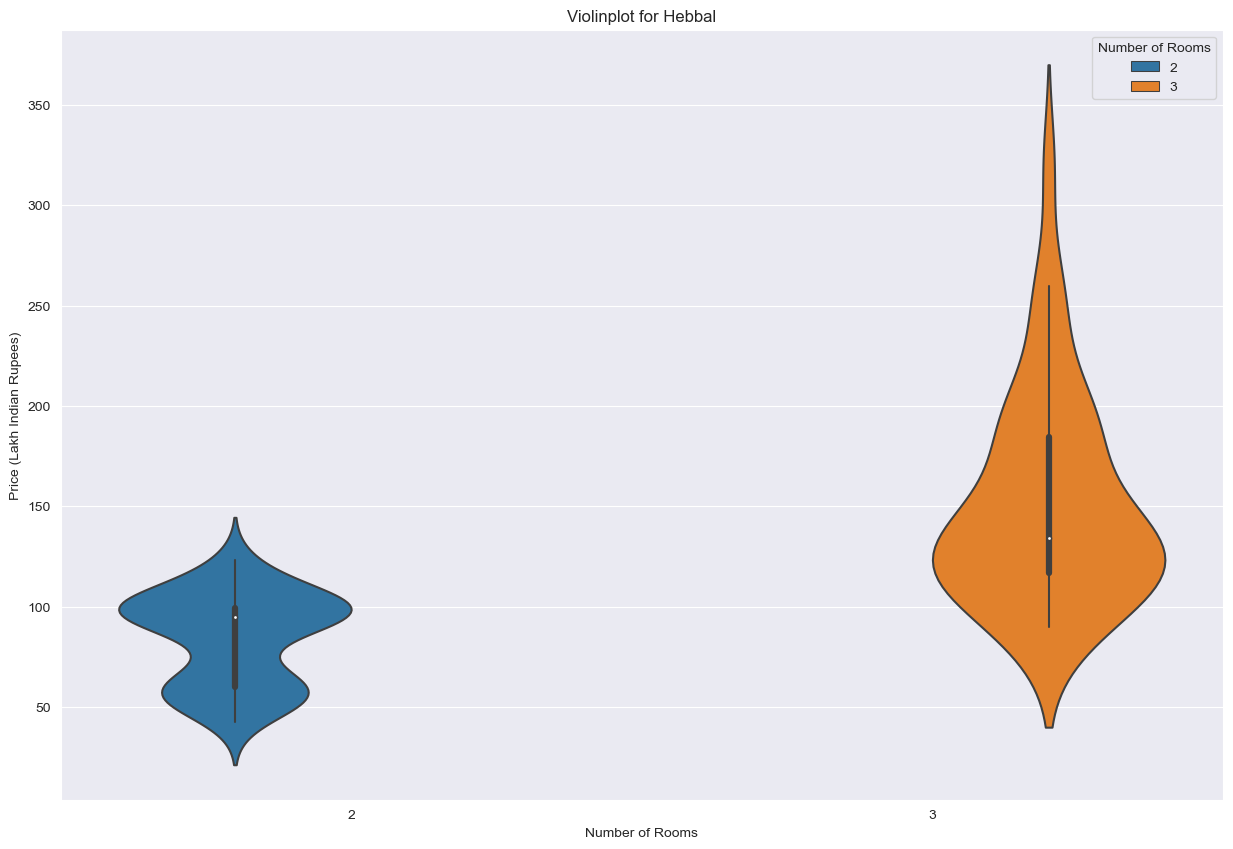

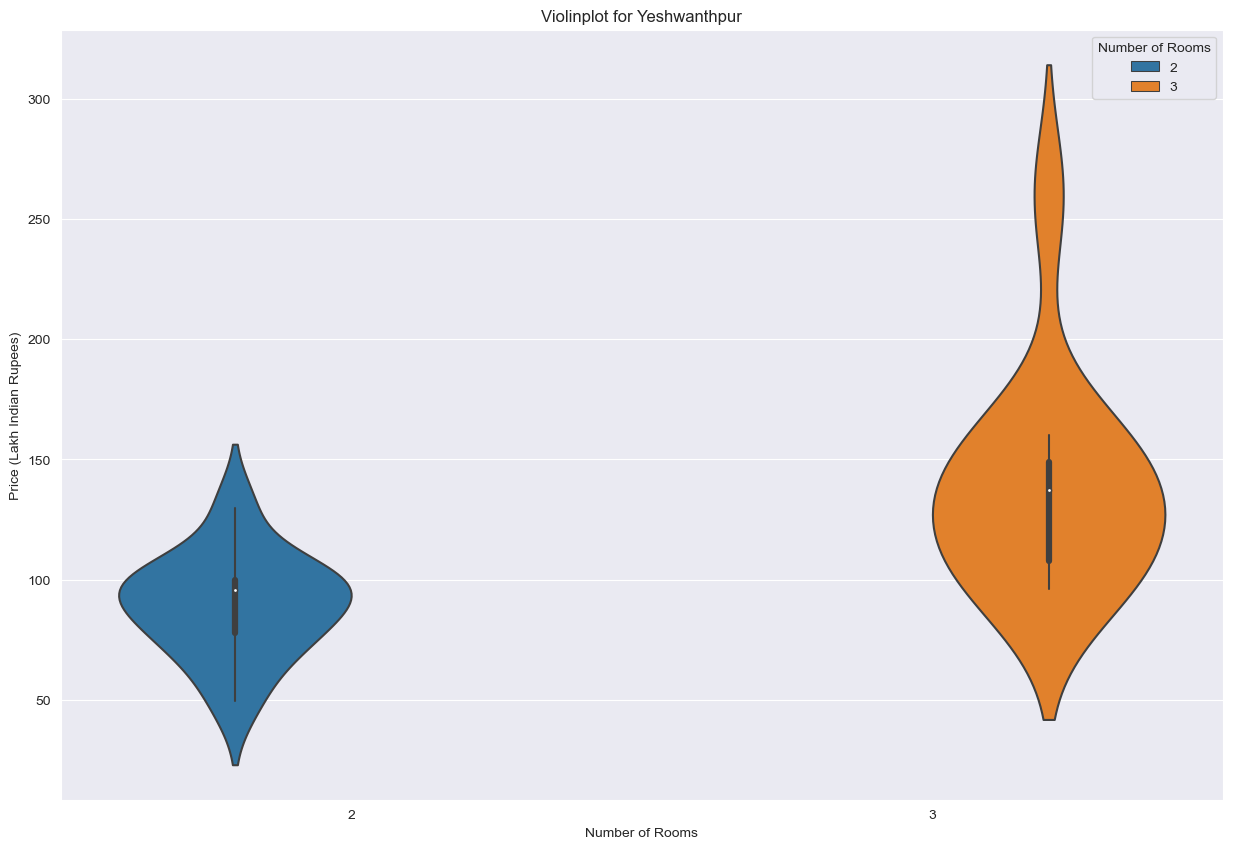

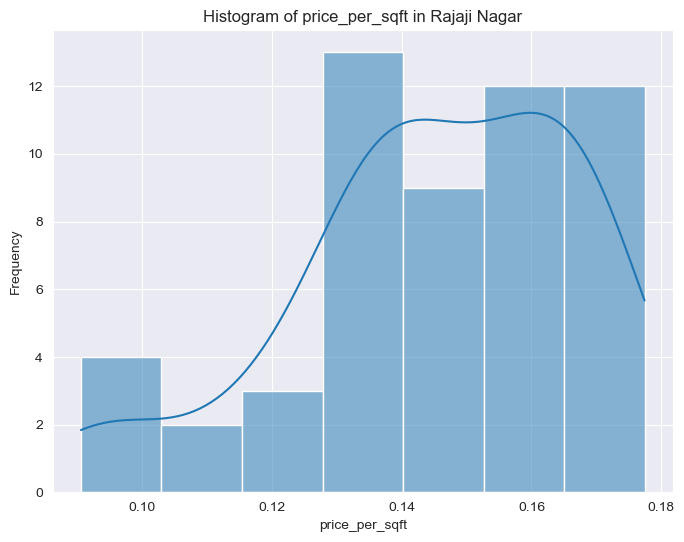

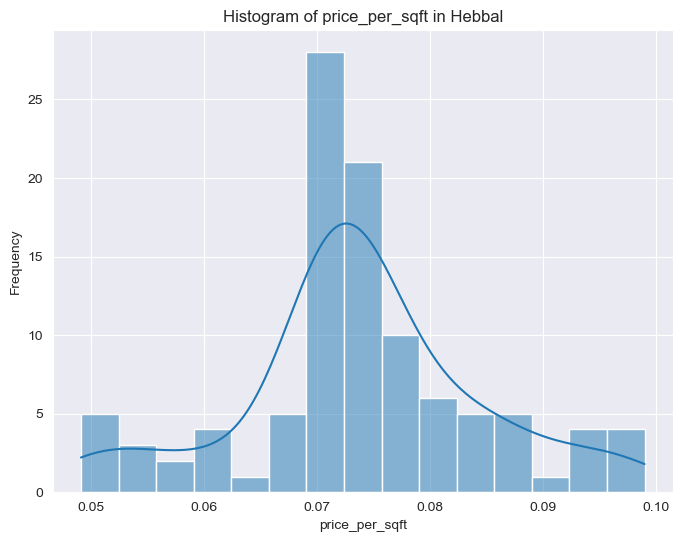

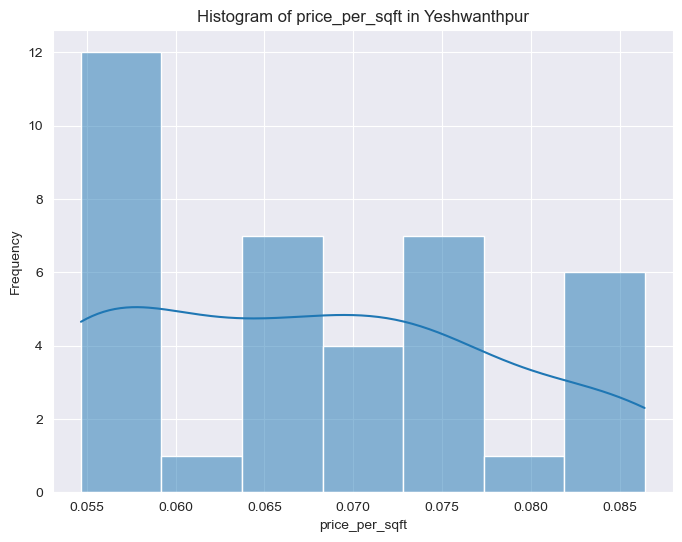

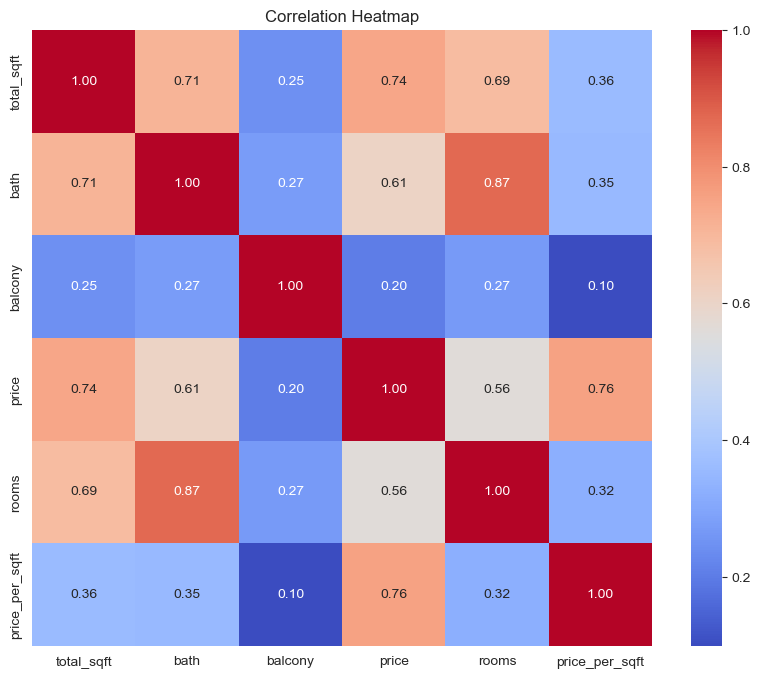

In [17]:
# See the scatter plots after the second removal
vd.plot_scatter_chart(second_outliers, "Rajaji Nagar")
vd.plot_scatter_chart(second_outliers, "Hebbal")
vd.plot_scatter_chart(second_outliers, "Yeshwanthpur")

# Show data after the second removal in box plots
vd.plot_boxplot(second_outliers, "Rajaji Nagar")
vd.plot_boxplot(second_outliers, "Hebbal")
vd.plot_boxplot(second_outliers, "Yeshwanthpur")

# Show data after the second removal in violins plot
vd.plot_violinplot(second_outliers, "Rajaji Nagar")
vd.plot_violinplot(second_outliers, "Hebbal")
vd.plot_violinplot(second_outliers, "Yeshwanthpur")

# Show data after the second removal in histograms
vd.plot_histogram(second_outliers, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(second_outliers, "price_per_sqft", "Hebbal")
vd.plot_histogram(second_outliers, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(second_outliers)

### Class to do PCA and UMAP

In [18]:
class DimensionalityReduction:
    def __init__(self, data, targets):
        """
        Initialize the DimensionalityReduction object with the dataset.

        Parameters:
        - data: The dataset to perform dimensionality reduction on.
        - targets: The targets of the samples.
        """
        self.data = StandardScaler().fit_transform(data)
        self.targets = targets

    def compute_pca(self, n_components=3):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(projection[:, 0], projection[:, 1], c=self.targets, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

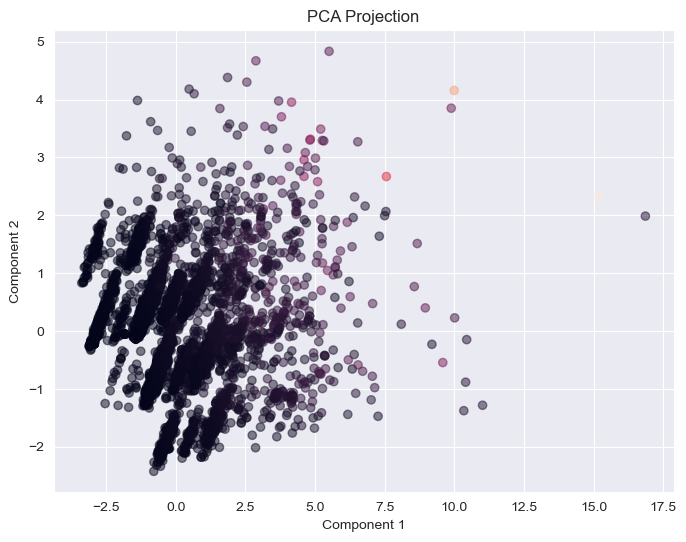

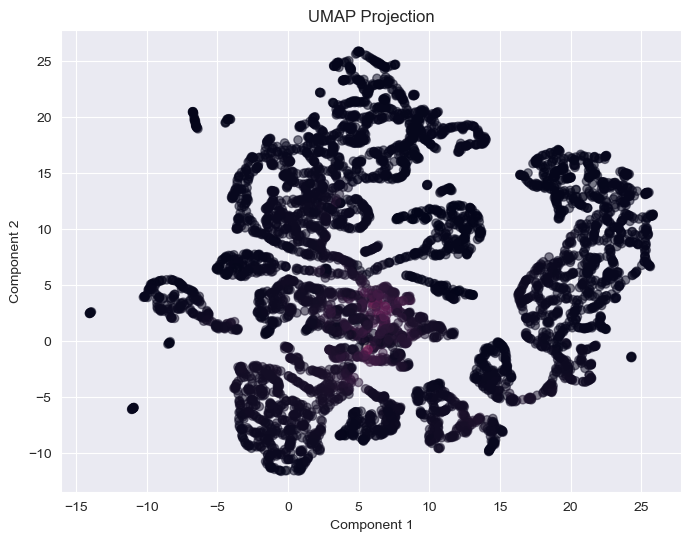

In [19]:
# Our data
data = second_outliers[['total_sqft', 'bath', 'balcony', 'rooms', 'price_per_sqft']]

# Our target
targets = second_outliers['price']

# Initialize DimensionalityReduction object
dr = DimensionalityReduction(data, targets)

# Show PCA Projection
dr.plot_projection(dr.compute_pca(), 'PCA Projection')

# Show UMAP Projection
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

### Class to do Hypothesis Test

In [20]:
class HypothesisTester:
    """
    The t-test assumes that the data is normally distributed and that the variances are equal between groups (for
    unpaired t-test) or within groups (for paired t-test).
    The ANOVA test assumes that the data is normally distributed and that the variances are equal between groups.
    """
    def unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def unpaired_anova(self, *groups):
        """
        Perform unpaired ANOVA for more than two groups.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - f_statistic: The calculated F-statistic.
        - p_value: The p-value associated with the F-statistic.
        """
        f_statistic, p_value = f_oneway(*groups)
        return f_statistic, p_value

    def paired_t_test(self, group1, group2):
        """
        Perform paired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.
                  Should have the same length as group1.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_rel(group1, group2)
        return t_statistic, p_value

In [21]:
# Prices per SQq. feet for three locations
price_sqft_Rajaji_Nagar = second_outliers[second_outliers['location'] == 'Rajaji Nagar']['price_per_sqft']
price_sqft_Hebbal = second_outliers[second_outliers['location'] == 'Hebbal']['price_per_sqft']
price_sqft_Yeshwanthpur = second_outliers[second_outliers['location'] == 'Yeshwanthpur']['price_per_sqft']

# Prices for Rajaji Nagar location
price_Rajaji_Nagar = second_outliers[second_outliers['location'] == 'Rajaji Nagar']['price']

# Total Sq. Feet for Rajaji Nagar location
total_sqft_Rajaji_Nagar = second_outliers[second_outliers['location'] == 'Rajaji Nagar']['total_sqft']

In [22]:
#Show Rajaji Nagar data
price_sqft_Rajaji_Nagar.head()

5546    0.135976
5548    0.139634
5549    0.169597
5550    0.143642
5551    0.149390
Name: price_per_sqft, dtype: float64

In [23]:
#Show Hebbal data
price_sqft_Hebbal.head()

2687    0.072646
2688    0.097475
2690    0.072646
2695    0.074992
2697    0.072738
Name: price_per_sqft, dtype: float64

In [24]:
#Show Yeshwanthpur data
price_sqft_Yeshwanthpur.head()

7653    0.054755
7654    0.075002
7655    0.073421
7656    0.069003
7659    0.055000
Name: price_per_sqft, dtype: float64

In [25]:
# Show data
price_Rajaji_Nagar.head()

5546    223.0
5548    229.0
5549    598.0
5550    340.0
5551    245.0
Name: price, dtype: float64

In [26]:
# Show data
total_sqft_Rajaji_Nagar.head()

5546    1640.0
5548    1640.0
5549    3526.0
5550    2367.0
5551    1640.0
Name: total_sqft, dtype: float64

In [27]:
# Initialize the HypothesisTester class with the data
tester = HypothesisTester()

In [28]:
# Perform unpaired t-test between Hebbal and Rajaji Nagar locations
t_stat, p_val = tester.unpaired_t_test(price_sqft_Hebbal, price_sqft_Rajaji_Nagar)

print("\nUnpaired t-test between Hebbal and Rajaji Nagar locations:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Unpaired t-test between Hebbal and Rajaji Nagar locations:
t-statistic: -27.820635247089612
p-value: 1.4416930569246122e-62


**Unpaired t-test between Hebbal and Rajaji Nagar locations:**
- t-statistic: The calculated t-statistic is approximately -27.82 (indicates that, on average, the price per Sq. Feet of Hebbal locations are lower than those of the Rajaji Nagar locations). This value represents the difference in means between the price per Sq. Feet of Hebbal and Rajaji Nagar locations.
* p-value: The p-value associated with the t-statistic is approximately 1.44e-62. This p-value is very small, indicating strong evidence against the null hypothesis.
+ In this case, it suggests that the difference in price per Sq. Feet between Hebbal and Rajaji Nagar locations is statistically significant.

In [29]:
# Perform unpaired ANOVA among the three locations
f_stat, p_val_anova = tester.unpaired_anova(price_sqft_Rajaji_Nagar, price_sqft_Hebbal, price_sqft_Yeshwanthpur)

print("\nUnpaired ANOVA among three locations:")
print("F-statistic:", f_stat)
print("p-value:", p_val_anova)


Unpaired ANOVA among three locations:
F-statistic: 498.0787471182691
p-value: 3.8294600777804645e-77


**Unpaired ANOVA among all three locations:**
- F-statistic: The calculated F-statistic is approximately 498.08. This value represents the ratio of variability between groups to variability within groups in price per Sq. Feet among three locations.
* p-value: The p-value associated with the F-statistic is approximately 3.83e-77. The t-test, this p-value is extremely small, indicating strong evidence against the null hypothesis.
+ It suggests that there is a statistically significant difference in price per Sq. Feet among at least one pair of locations.

In [30]:
# Perform paired t-test for total_sqft and price within Rajaji Nagar location
t_stat, p_val = tester.paired_t_test(total_sqft_Rajaji_Nagar, price_Rajaji_Nagar)

print("\nPaired t-test for total_sqft and price within Rajaji Nagar location:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Paired t-test for total_sqft and price within Rajaji Nagar location:
t-statistic: 23.205271161231476
p-value: 9.248274092260672e-30


**Paired t-test for total_sqft and price within Rajaji Nabar location:**
- t-statistic: The calculated t-statistic is approximately 23.21. This value represents the difference in means between total_sqft and price within the Rajaji Nagar location relative to the variability in the data.
* p-value: The p-value associated with the t-statistic is approximately 9.25e-30. This p-value is extremely small, indicating strong evidence against the null hypothesis.
+ It suggests that the difference between total_sqft and price within the Rajaji Nagar location is statistically significant.

### New Features

In [32]:
# Price distribution per bedroom.
second_outliers['price_per_bedroom'] = second_outliers['price'] / second_outliers['rooms']

# Bathroom to bedroom ratio.
second_outliers['bath_per_bedroom'] = second_outliers['bath'] / second_outliers['rooms']

# Space distribution per bedroom.
second_outliers['total_sqft_per_room'] = second_outliers['total_sqft'] / second_outliers['rooms']

# Balcony to bedroom ratio
second_outliers['balcony_per_room'] = second_outliers['balcony'] / second_outliers['rooms']

# Price distribution per bathroom
second_outliers['price_per_bath'] = second_outliers['price'] / second_outliers['bath']

# Space distribution per bathroom
second_outliers['total_sqft_per_bath'] = second_outliers['total_sqft'] / second_outliers['bath']

# Balcony to bathroom ratio
second_outliers['balcony_per_bath'] = second_outliers['balcony'] / second_outliers['bath']

# Price distribution per balcony
second_outliers['price_per_balcony'] = second_outliers['price'] / second_outliers['balcony']

# Space distribution per balcony
second_outliers['total_sqft_per_balcony'] = second_outliers['total_sqft'] / second_outliers['balcony']

# Bedroom to bathroom ratio
second_outliers['room_per_bath'] = second_outliers['rooms'] / second_outliers['bath']

# Calculate the average price
average_price = second_outliers['price'].mean()

# Prices above average
second_outliers['price_above_average'] = second_outliers['price'] > average_price

print("New features added to the dataset:")
print(second_outliers.columns)

# Show the new features
print(second_outliers[['price_per_bedroom', 'bath_per_bedroom', 'total_sqft_per_room', 'balcony_per_room',
                      'price_per_bath', 'total_sqft_per_bath', 'balcony_per_bath', 'price_per_balcony',
                      'total_sqft_per_balcony', 'room_per_bath', 'price_above_average']].head())

New features added to the dataset:
Index(['location', 'total_sqft', 'bath', 'balcony', 'price', 'rooms',
       'price_per_sqft', 'price_per_bedroom', 'bath_per_bedroom',
       'total_sqft_per_room', 'balcony_per_room', 'price_per_bath',
       'total_sqft_per_bath', 'balcony_per_bath', 'price_per_balcony',
       'total_sqft_per_balcony', 'room_per_bath', 'price_above_average'],
      dtype='object')
   price_per_bedroom  bath_per_bedroom  total_sqft_per_room  balcony_per_room  \
0          23.500000          1.000000           558.000000          0.500000   
1          21.666667          0.666667           475.000000          0.666667   
2          25.333333          0.666667           472.333333          0.666667   
3          20.000000          1.000000           495.500000          1.000000   
5          21.500000          1.000000           473.500000          1.000000   

   price_per_bath  total_sqft_per_bath  balcony_per_bath  price_per_balcony  \
0            23.5           

### Model Selection Class

In [43]:
class ModelSelection:
    """
    A class to perform model selection for regression problems.
    """
    def __init__(self, X, y):
        """
        Initializes the ModelSelection object with the features and target variable.

        :param X: The input features.
        :param y: The target variable.
        """
        self.X = X
        self.y = y

    def select_model(self):
        """
        Performs model selection by training various models and evaluating them using Mean Squared Error.
        The models used are: Linear Regression, Decision Tree Regression, Random Forest Regression,
        Gradient Boosting Regression, and Support Vector Regression.
        """
        # Create a list of models to evaluate
        models = [RandomForestRegressor(), GradientBoostingRegressor(), LinearRegression(), DecisionTreeRegressor(), SVR(), Ridge()]

        for model in models:
            # Perform K-Fold Cross Validation
            scores = cross_val_score(model, self.X, self.y, cv=10, scoring='neg_mean_squared_error')

            # Calculate Mean Squared Error
            mse_scores = -scores

            # Print the model name and its Mean Squared Error
            print(f'Model: {model.__class__.__name__}, Mean Squared Error: {mse_scores.mean()}')

            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

            # Fit the model to the training data
            model.fit(X_train, y_train)

            # Plot the model's predictions
            self.plot_model_predictions(X_test, y_test, model)

    def plot_model_predictions(self, X_test, y_test, model):
        '''
        Plots the model's predictions against the actual values
        :param X_test: Test data
        :param y_test: Actual values
        :param model: Trained model
        '''

        # Use the model to make predictions on the test data
        predictions = model.predict(X_test)

        # Plot the model's predictions against the actual values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model.__class__.__name__} Model: Actual vs Predicted Values')

        # Add a line representing perfect prediction
        min_val = min(min(y_test), min(predictions))
        max_vals = max(max(y_test), max(predictions))
        plt.plot([min_val, max_vals], [min_val, max_vals], color='red')

        plt.show()

### Model Selection

In [45]:
second_outliers_encoded = pd.get_dummies(second_outliers)
second_outliers_encoded.fillna(second_outliers_encoded.mean(), inplace=True)

for column in second_outliers_encoded.columns:
    if np.isinf(second_outliers_encoded[column]).any():
        max_val = second_outliers_encoded[~np.isinf(second_outliers_encoded[column])][column].max()
        second_outliers_encoded[column] = second_outliers_encoded[column].replace([np.inf, -np.inf], max_val)

# Now, 'second_outliers_encoded' is your DataFrame with encoded categorical variables
X = second_outliers_encoded.drop(['price'], axis=1)
y = second_outliers_encoded['price']

# Initialize the ModelSelection class with the data
ms = ModelSelection(X, y)

# Perform model selection
ms.select_model()

NameError: name 'GradientBoostingRegressor' is not defined

Model: RandomForestRegressor, Mean Squared Error: 528.772861394486
Model: GradientBoostingRegressor, Mean Squared Error: 397.67993235900605
Model: LinearRegression, Mean Squared Error: 2.72004223219524e+18
Model: DecisionTreeRegressor, Mean Squared Error: 504.8797214036189
Model: SVR, Mean Squared Error: 3995.591255828652
Model: Ridge, Mean Squared Error: 269.8387993504342

These are one of the possible results of the models.